|Name|Affiliation|IEEE Member|SSCS Member|
|:--:|:----------:|:----------:|:----------:|
|HyungJoo Park <br /> Email ID: pikkoro97@hanyang.ac.kr|Hanyang University, Seoul, Korea|Yes|No|
|Sungyoung Lee <br /> Email ID: brianlsy@snu.ac.kr|Seoul National University, Seoul, Korea|Yes|No|
|Jaeduk Han|Hanyang University, Seoul, Korea|Yes|Yes|

## **Process-Portable Full-Custom Memory Compiler using Laygo2 with Yosys Integration**
A Full-custom DFFRAM layout generator using laygo2

SPDX-License-Identifier: Apache-2.0

Draw a 1k-bit DFFRAM with subcells for the SKY130 technology using [laygo2](https://laygo2.github.io)[1] with LVS and schematic level simulation

**Object: Generate a 1k-bit custom register file (which is inspired by [DFFRAM](https://github.com/AUCOHL/DFFRAM)[2]) for SKY130 technology using [laygo2](https://laygo2.github.io) and [Yosys](https://github.com/YosysHQ/yosys)[3]**

In this Notebook, we are demonstrating a hybrid approach (custom + synthesized digital) to generate a custom memory block using laygo2 and Yosys.

The memory core and transistor-centric sub-blocks are generated by laygo2 for performance. Gate-centric sub-blocks are described in Verilog and synthesized to gate-level netlists by Yosys (by utilizing the standard cell library constructed by laygo2). The gate-level netlists are then loaded in laygo2 and converted to physical layouts.

The memory cell and organization follow DFFRAM, which is an open-sourced memory cell generator utilizing standard cell libraries. In this work, we focus on generating the layout from customized cells for further optimization and integrating the logic synthesis flow to enhance design productivity.

By following the instructions provided in this notebook, you'll be able to generate and test the custom DFFRAM cell.

### About Full Custom DFFRAM

While memory registers such as cache are generated using memory compilers including [DFFRAM](https://github.com/AUCOHL/DFFRAM), [OpenRAM](https://openram.org/)[4], there are demands on customized memory registers for various purposes including the following 1) standard cells are not available for the voltage domain and transistor types for the target circuits 2) propagation delay optimization problem on standard cells. Though the register that generated from this notebook is not optimized yet, owing to the property of laygo2, this complier can be easily implemented on other technology such as GF180. And expected to be easily optimized by implementing proper unit mosfet.

The Full-Custom DFFRAM layout is automatically generated by laygo2, an automated layout generation framework for custom circuits, developed/maintained by Nifty Chips Laboratory at Hanyang University, Seoul, South Korea.

### About Yosys Integration

Though laygo2 can perform automatic routing by assigning net-names to each pins of instances, this feature has been hardly used because assigning a netname to each pin was a very labor-intensive task. In order to properly use this feature, Yosys integration was implemented by creating a module that passes the synthesized netlist to Laygo2. This enables the design of custom logic circuits by using Verilog to describe circuit behavior and using Laygo2 as a kind of PnR engine. The detailed generation flow is presented after the simulation of RAM32 circuit.

### Schematic and Simulation Preview

You can see the logic structure of DFFRAM at 'Overview' part in [DFFRAM](https://github.com/AUCOHL/DFFRAM).

The figures below show schematics of memory cells described in [DFFRAM](https://github.com/AUCOHL/DFFRAM).

![byte_cell_schematic](https://drive.google.com/uc?id=14kNLOvPYD5qS-GWJV229JCBvqLyYolJT)

Figure1. Byte cell schematic.

![Word_cell_schematic](https://drive.google.com/uc?id=1K809LfMpnwoYm9Vc0i7tEeddO6MJY1Fp)

Figure2. 32-bit WORD cell schematic.

![RAM_cell_schematic](https://drive.google.com/uc?id=1IcQtDo6sEWAmjBT5tS9pwkci0Bsr5QvG)

Figure3. 1k-bit RAM cell schematic.


'SEL' bits activate WORD cell and 'WE' bits select bytes in each WORD cells by enabling CLK-gate array. The Byte cells are activated by its CLK-gate.

Since 'SEL' signal actuvates not only CLK-gate but also tri-state buffers for data output, 36 finger buffers are implemented for each WORD cell to deal with large fanout.

Transmission gates are used for additional CLK-gate to reduce fanout of CLK input of 32 WORD cells. Simulation shows that voltage loss due to the transmission gates is sufficiently small.

This figure shows CLK buffer chain simulation result for fanout of clk input of 32 word cells. You can see the output of buffer chain flows external clk signal with sufficient delay margin for post simulation.

![SIM_CLK_buf](https://drive.google.com/uc?id=1ZCj1z31x8iapi3UlCnr_SBOAFQW6y8Wx)

Figure4. Clock buffer delay.

This figure shows a schematic level simulation of write operation using a 100MHz clock signal. 'CLK_WORD' represents output of CLK-gate controled by (SEL & WE) signal. You can see the output 'Do' signal follows at rising edge of CLK_WORD.

![SIM_write](https://drive.google.com/uc?id=10b47OwT3opXjtdBP6Cxi4OPoC0AjkVTW)

Figure5. RAM write operation.

### Generation Flow

The memory array is generated from the following steps which translate laygo2 generators and Verilog descriptions into GDS and spice netlists.

1. Compile Python scripts with laygo2 to generate TCL files for magic.
2. Read the TCL files with magic to generate layout.
3. Extract GDS and SPICE with magic.
4. Run LVS check with netgen and simulation with ngspice

### Install conda and dependencies

In [45]:
import os

CONDA_PREFIX = os.environ.get('CONDA_PREFIX', None)
if not CONDA_PREFIX:
  !python -m pip install condacolab
  import condacolab
  condacolab.install()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
✨🍰✨ Everything looks OK!


In [3]:
%%writefile environment.yml
channels:
  - litex-hub
  - conda-forge
dependencies:
  - open_pdks.sky130a
  - magic
  - gdstk
  - ngspice
  - iverilog
  - bison
  - pip
  - pip:
    - gdspy
    - pyyaml
    - cairosvg
    - pyverilog

Writing environment.yml


In [4]:
!mamba env update -n base -f environment.yml

[+] 0.0s
[+] 0.1s
litex-hub/linux-64    ⣾  
litex-hub/noarch      ⣾  
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 0.2s
litex-hub/linux-64    ⣾  
litex-hub/noarch      ⣾  
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 0.3s
litex-hub/linux-64    ⣾  
litex-hub/noarch      ⣾  
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 0.4s
litex-hub/linux-64    ⣾  
litex-hub/noarch      ⣾  
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 0.5s
litex-hub/linux-64    ⣾  
litex-hub/noarch      ⣾  
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  litex-hub/noarch                                  
[+] 0.6s
litex-hub/linux-64    ⣾  
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 0.7s
litex-hub/linux-64    ⣾  
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 0.8s
litex-hub/linux-64    ⣾  
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 0.9s
litex-hub/linux-64    ⣾  
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 1.0s
litex-hub/linux-64    ⣾  
c

In [5]:
import os

CONDA_PREFIX = os.environ.get('CONDA_PREFIX', None)
if not CONDA_PREFIX:
  import condacolab
  CONDA_PREFIX = condacolab.PREFIX

### Install the laygo2 workspace for the sky130 technology

In [6]:
%cd /content/
!rm -rf laygo2_workspace_sky130
!git clone https://github.com/RTimothyEdwards/netgen.git
%cd netgen
!./configure 
!make 
!make install
%cd ../
!git clone https://github.com/niftylab/laygo2_workspace_sky130.git
%cd laygo2_workspace_sky130
!git submodule init
!git submodule update --remote


/content
Cloning into 'netgen'...
remote: Enumerating objects: 3028, done.
remote: Counting objects: 100% (563/563), done.
remote: Compressing objects: 100% (227/227), done.
remote: Total 3028 (delta 380), reused 453 (delta 303), pack-reused 2465
Receiving objects: 100% (3028/3028), 2.71 MiB | 11.97 MiB/s, done.
Resolving deltas: 100% (1706/1706), done.
/content/netgen
checking build system type... x86_64-unknown-linux-gnu
checking host system type... x86_64-unknown-linux-gnu
checking target system type... x86_64-unknown-linux-gnu
checking for gcc... gcc
checking whether the C compiler works... yes
checking for C compiler default output file name... a.out
checking for suffix of executables... 
checking whether we are cross compiling... no
checking for suffix of object files... o
checking whether we are using the GNU C compiler... yes
checking whether gcc accepts -g... yes
checking for gcc option to accept ISO C89... none needed
checking how to run the C preprocessor... gcc -E
checking 

### RAM32 Write Operation Simulation

Simulate write operation and WORD changing operation with 100mhz CLK.

note: It would takes long time.

### Import packages, set parameters, and load templates/grids

In [7]:
%cd /content/laygo2_workspace_sky130

/content/laygo2_workspace_sky130


In [8]:
import sys
sys.path.append("/content/laygo2_workspace_sky130/laygo2")
print(sys.path)

['/usr/local/lib/python3.10/site-packages', '/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython', '/content/laygo2_workspace_sky130/laygo2']


In [9]:
import numpy as np
import pprint
import laygo2
import laygo2.interface
import laygo2_tech as tech
tpmos_name = 'pmos_sky'
tnmos_name = 'nmos_sky'
tptap_name = 'ptap_sky'
tntap_name = 'ntap_sky'
templates = tech.load_templates()
tpmos, tnmos = templates[tpmos_name], templates[tnmos_name]

pg_name = 'placement_basic'
r12_name = 'routing_12_cmos'
r23_name = 'routing_23_cmos'
grids = tech.load_grids(templates=templates)
pg, r12, r23 = grids[pg_name], grids[r12_name], grids[r23_name]

### Generate primary logic subcells
Inverter

Tri-state Inverter

Buffer

Nand

3-input Nand

Nor

Transmission Gate

2-phase Clock Latch

D Flip-Flop

TAP

Mux-2to1

In [10]:
exec(open("laygo2_example/logic/inv.py").read())
exec(open("laygo2_example/logic/tinv.py").read())
exec(open("laygo2_example/logic/tinv_small_1x.py").read())
exec(open("laygo2_example/logic/space.py").read())
exec(open("laygo2_example/logic/buffer.py").read())
exec(open("laygo2_example/logic/nand.py").read())
exec(open("laygo2_example/logic/nand3.py").read())
exec(open("laygo2_example/logic/nor.py").read())
exec(open("laygo2_example/logic/tgate.py").read())
exec(open("laygo2_example/logic/latch_2ck.py").read())
exec(open("laygo2_example/logic/dff.py").read())
exec(open("laygo2_example/logic/tap.py").read())
exec(open("laygo2_example/logic/mux2to1.py").read())

Load templates
<laygo2.object.template.core.UserDefinedTemplate object at 0x7feb7737c430> name: pmos_sky, class: UserDefinedTemplate, 
<laygo2.object.template.core.UserDefinedTemplate object at 0x7feb7737e9e0> name: nmos_sky, class: UserDefinedTemplate, 
Load grids
 name: placement_basic, 
 class: PlacementGrid, 
 scope: [[0, 0], [72, 24]], 
 elements: [array([0]), array([0])], 

 name: routing_12_cmos, 
 class: RoutingGrid, 
 scope: [[0, 0], [72, 1008]], 
 elements: [array([0]), array([  0, 144, 216, 360, 504, 648, 792, 864])], 
 vwidth: <laygo2.object.grid.core.CircularMapping object at 0x7feb77640cd0> class: CircularMapping, elements: [30]
 hwidth: <laygo2.object.grid.core.CircularMapping object at 0x7feb77641570> class: CircularMapping, elements: [60 30 30 30 30 30 30 30]
 vextension: <laygo2.object.grid.core.CircularMapping object at 0x7feb77642d10> class: CircularMapping, elements: [10]
 hextension: <laygo2.object.grid.core.CircularMapping object at 0x7feb77641ed0> class: Circula

### Generate Advanced logic subcells
4-input And

Integrated Clock Gate (ICG)

Decoder-2x4

Decoder-3x8


In [11]:
exec(open("laygo2_example/logic_advance/and4.py").read())
exec(open("laygo2_example/logic_advance/clk_gate.py").read())
exec(open("laygo2_example/logic_advance/dec2x4.py").read())
exec(open("laygo2_example/logic_advance/dec3x8.py").read())

Load templates
Load grids
--------------------
Now Creating and4_2x
Create instances
Create wires
Export design
Load templates
Load grids
--------------------
Now Creating cgate_2x
Create instances
Create wires
Export design
Load templates
Load grids
--------------------
Now Creating dec2x4_2x
Create instances
Create wires
Export design
Load templates
Load grids
--------------------
Now Creating dec3x8_2x
Create instances
Create wires
Export design


### Generate a DFF-based Byte register Cell

In [12]:
# Variables
cell_type = 'ram32_v2'
nf=2
words_num = 32 # must be an even number
buffer_num = 8+4+1 # number of buffers
# Templates
tpmos_name = 'pmos_sky'
tnmos_name = 'nmos_sky'
tptap_name = 'ptap_sky'
tntap_name = 'ntap_sky'
# Grids
pg_name = 'placement_basic'
r12_name = 'routing_12_cmos'
r23_basic_name = 'routing_23_basic'
r23_cmos_name = 'routing_23_cmos'
r34_name = 'routing_34_basic'
# Design hierarchy
libname = 'logic_advanced'
ref_dir_template = './laygo2_example/' #export this layout's information into the yaml in this dir 
ref_dir_export = './laygo2_example/logic_advance/'
ref_dir_MAG_exported = './laygo2_example/logic_advance/TCL/'
ref_dir_layout = './magic_layout'
# End of parameter definitions ######

# Generation start ##################
# 1. Load templates and grids.
print("Load templates")
templates = tech.load_templates()
tpmos, tnmos = templates[tpmos_name], templates[tnmos_name]
tlogic_prim = laygo2.interface.yaml.import_template(filename=ref_dir_template+'logic/logic_generated_templates.yaml')
tlogic_adv = laygo2.interface.yaml.import_template(filename=ref_dir_template+'logic_advance/logic_advanced_templates.yaml')

print("Load grids")
grids = tech.load_grids(templates=templates)
pg, r12, r23_cmos, r23, r34 = grids[pg_name], grids[r12_name], grids[r23_cmos_name], grids[r23_basic_name], grids[r34_name]

# Variables
cell_type = 'byte_dff'
nf=2
# Generation start ##################

cellname = cell_type+'_'+str(nf)+'x'
print('--------------------')
print('Now Creating '+cellname)

# 2. Create a design hierarchy
lib = laygo2.object.database.Library(name=libname)
dsn = laygo2.object.database.Design(name=cellname, libname=libname)
lib.append(dsn)

# 3. Create istances.
print("Create instances")
inv_sel = tlogic_prim['inv_'+str(nf)+'x'].generate(name='inv_sel')
inv_and = tlogic_prim['inv_'+str(nf)+'x'].generate(name='inv_and')
nand = tlogic_prim['nand_'+str(nf)+'x'].generate(name='nand')
cgate = tlogic_adv['cgate_'+str(nf)+'x'].generate(name='cgate0')
cells=list()
for i in range(8):
    cells.append(tlogic_prim['dff_'+str(nf)+'x'].generate(name='dff_'+str(i)))
    cells.append(tlogic_prim['inv_'+str(nf)+'x'].generate(name='inv'+str(i)))
    cells.append(tlogic_prim['tinv_'+str(nf)+'x'].generate(name='tinv'+str(i)))

# 4. Place instances.
dsn.place(grid=pg, inst=nand, mn=[0,0])
dsn.place(grid=pg, inst=inv_and, mn=pg.mn.bottom_right(nand))
dsn.place(grid=pg, inst=inv_sel, mn=pg.mn.bottom_right(inv_and))
dsn.place(grid=pg, inst=cgate, mn=pg.mn.bottom_right(inv_sel))
dsn.place(grid=pg, inst=cells, mn=pg.mn.bottom_right(cgate))

# 5. Create and place wires.
print("Create wires")
# sel
mn_list = [r34.mn(nand.pins['B'])[0], r34.mn(inv_sel.pins['I'])[0]]
for i in range(8):
    mn_list.append(r34.mn(cells[3*i+2].pins['EN'])[0]) # ~= cells[i].tinv.pins[EN]
_track = [None, r34.mn(inv_sel.pins['O'])[0,1]-1]
rsel = dsn.route_via_track(grid=r34, mn=mn_list, track=_track)

# sel_bar
mn_list = [r34.mn(inv_sel.pins['O'])[0]]
for i in range(8):
    mn_list.append(r34.mn(cells[3*i+2].pins['ENB'])[0]) # ~= cells[i].tinv.pins[ENB]
_track = [None, r34.mn(inv_sel.pins['O'])[0,1]+1]
dsn.route_via_track(grid=r34, mn=mn_list, track=_track)

# Nand_inv
mn_list = [ r23.mn(nand.pins['OUT'])[0], r23.mn(inv_and.pins['I'])[0] ]
_track = [None, (r23.mn(inv_and.pins['I'])[0,1]+r23.mn(inv_and.pins['I'])[1,1])/2]
dsn.route_via_track(grid=r23, mn=mn_list, track=_track)

# clock en
mn_list = [r23.mn(inv_and.pins['O'])[0], r23.mn(cgate.pins['EN'])[0] ]
_track = [None,(r23.mn(cgate.pins['EN'])[0,1]+r23.mn(cgate.pins['EN'])[1,1])/2]
dsn.route_via_track(grid=r23, mn=mn_list, track=_track)

# clk flip flop
mn_list = [r34.mn(cgate.pins['CK_O'])[0]]
for i in range(8):
    mn_list.append(r34.mn(cells[3*i].pins['CLK'])[0])
_track = [None, r34.mn(cgate.pins['CK_O'])[0,1]]
dsn.route_via_track(grid=r34, mn=mn_list, track=_track)

# cell internal
for i in range(8):
    # dff_out <--> inv_in
    mn_list = [r23.mn(cells[3*i].pins['O'])[0], r23.mn(cells[3*i+1].pins['I'])[0]]
    _track = [None, (r23.mn(cells[3*i+1].pins['I'])[0,1] + r23.mn(cells[3*i+1].pins['I'])[1,1])/2]
    dsn.route_via_track(grid=r23, mn=mn_list, track=_track)
    # inv_out <--> tinv_in
    mn_list = [r23.mn(cells[3*i+1].pins['O'])[0], r23.mn(cells[3*i+2].pins['I'])[0]]
    _track = [None, (r23.mn(cells[3*i+2].pins['I'])[0,1] + r23.mn(cells[3*i+2].pins['I'])[1,1])/2]
    dsn.route_via_track(grid=r23, mn=mn_list, track=_track)

# VSS
rvss0 = dsn.route(grid=r12, mn=[r12.mn.bottom_left(nand), r12.mn.bottom_right(cells[3*8-1])])

# VDD
rvdd0 = dsn.route(grid=r12, mn=[r12.mn.top_left(nand), r12.mn.top_right(cells[3*8-1])])

# 6. Create pins.
psel =  dsn.pin(name='SEL', grid=r34, mn=r34.mn.bbox(rsel[-1]))
pwe = dsn.pin(name='WE', grid=r23_cmos, mn=r23_cmos.mn.bbox(nand.pins['A']))
pclk = dsn.pin(name='CLK', grid=r23_cmos, mn=r23_cmos.mn.bbox(cgate.pins['CK_I']))
pDo = list()
pDi = list()
for i in range(8):
    pDo.append(dsn.pin(name='Do<'+str(7-i)+'>', grid=r23_cmos, mn=r23_cmos.mn.bbox(cells[3*(7-i)+2].pins['O'])))
    pDi.append(dsn.pin(name='Di<'+str(7-i)+'>', grid=r23_cmos, mn=r23_cmos.mn.bbox(cells[3*(7-i)].pins['I'])))
# pA2bar = dsn.pin(name='A2bar', grid=r23_cmos, mn=r23_cmos.mn.bbox(inv0.pins['O']))

pvss0 = dsn.pin(name='VSS', grid=r12, mn=r12.mn.bbox(rvss0))
pvdd0 = dsn.pin(name='VDD', grid=r12, mn=r12.mn.bbox(rvdd0))

# 7. Export to physical database.
print("Export design")

# Uncomment for BAG export
laygo2.interface.magic.export(lib, filename=ref_dir_MAG_exported +libname+'_'+cellname+'.tcl', cellname=None, libpath=ref_dir_layout, scale=1, reset_library=False, tech_library='sky130A')

# 8. Export to a template database file.
nat_temp = dsn.export_to_template()
laygo2.interface.yaml.export_template(nat_temp, filename=ref_dir_export+libname+'_templates.yaml', mode='append')

Load templates
Load grids
--------------------
Now Creating byte_dff_2x
Create instances
Create wires
Export design


{'logic_advanced': {'and4_2x': {'bbox': [[0, 0], [1728, 1008]],
   'cellname': 'and4_2x',
   'libname': 'logic_advanced',
   'pins': {'A': {'layer': ['M3', 'pin'],
     'name': 'A',
     'netname': 'A',
     'xy': [[921, 360], [951, 648]]},
    'B': {'layer': ['M3', 'pin'],
     'name': 'B',
     'netname': 'B',
     'xy': [[705, 360], [735, 648]]},
    'C': {'layer': ['M3', 'pin'],
     'name': 'C',
     'netname': 'C',
     'xy': [[345, 360], [375, 648]]},
    'D': {'layer': ['M3', 'pin'],
     'name': 'D',
     'netname': 'D',
     'xy': [[129, 360], [159, 648]]},
    'VDD': {'layer': ['M2', 'pin'],
     'name': 'VDD',
     'netname': 'VDD',
     'xy': [[0, 978], [1728, 1038]]},
    'VSS': {'layer': ['M2', 'pin'],
     'name': 'VSS',
     'netname': 'VSS',
     'xy': [[0, -30], [1728, 30]]},
    'Y': {'layer': ['M3', 'pin'],
     'name': 'Y',
     'netname': 'Y',
     'xy': [[1569, 216], [1599, 864]]}}},
  'cgate_2x': {'bbox': [[0, 0], [3456, 1008]],
   'cellname': 'cgate_2x',
   'l

### Generate 32-bit Word

In [13]:
# Parameter definitions #############
# Variables
cell_type = 'word_2row'
nf=2
# Templates
tpmos_name = 'pmos_sky'
tnmos_name = 'nmos_sky'
tptap_name = 'ptap_sky'
tntap_name = 'ntap_sky'
# Grids
pg_name = 'placement_basic'
r12_name = 'routing_12_cmos'
r23_basic_name = 'routing_23_basic'
r23_cmos_name = 'routing_23_cmos'
r34_name = 'routing_34_basic'
# Design hierarchy
libname = 'logic_advanced'
ref_dir_template = './laygo2_example/' #export this layout's information into the yaml in this dir 
ref_dir_export = './laygo2_example/logic_advance/'
ref_dir_MAG_exported = './laygo2_example/logic_advance/TCL/'
ref_dir_layout = './magic_layout'
# End of parameter definitions ######

# Generation start ##################
# 1. Load templates and grids.
print("Load templates")
templates = tech.load_templates()
tpmos, tnmos = templates[tpmos_name], templates[tnmos_name]
tlogic_prim = laygo2.interface.yaml.import_template(filename=ref_dir_template+'logic/logic_generated_templates.yaml')
tlogic_adv = laygo2.interface.yaml.import_template(filename=ref_dir_template+'logic_advance/logic_advanced_templates.yaml')

print("Load grids")
grids = tech.load_grids(templates=templates)
pg, r12, r23_cmos, r23, r34 = grids[pg_name], grids[r12_name], grids[r23_cmos_name], grids[r23_basic_name], grids[r34_name]

cellname = cell_type+'_'+str(nf)+'x'
print('--------------------')
print('Now Creating '+cellname)

# 2. Create a design hierarchy
lib = laygo2.object.database.Library(name=libname)
dsn = laygo2.object.database.Design(name=cellname, libname=libname)
lib.append(dsn)

# 3. Create istances.
print("Create instances")

cells=list()
for i in range(2):
    cells.append(tlogic_adv['byte_dff_'+str(nf)+'x'].generate(name='byte_dff'+str(i*2)))
    cells.append(tlogic_adv['byte_dff_'+str(nf)+'x'].generate(name='byte_dff'+str(i*2+1), transform='MX'))
buf_sel=[]
buf_sel.append(tlogic_prim['inv_'+str(36)+'x'].generate(name='inv_sel0', transform='MX'))
buf_sel.append(tlogic_prim['inv_'+str(36)+'x'].generate(name='inv_sel1', transform='MY'))
tgate0 = tlogic_prim['tgate_'+str(nf)+'x'].generate(name='gate_clk')
NTAP1 = templates[tntap_name].generate(name='MNT1', transform='MX', params={'nf':4, 'tie':'TAP0'})
PTAP1 = templates[tptap_name].generate(name='MPT1', params={'nf':4, 'tie':'TAP0'})

# 4. Place instances.
_TAP = [0]*2
_TAP[1] = [NTAP1]
_TAP[0] = [PTAP1]

mn_ref = [0,0]
dsn.place(grid=pg, inst=cells[0], mn=mn_ref)
mn_ref = pg.mn.top_left(cells[0]) + pg.mn.height_vec(cells[1])
dsn.place(grid=pg, inst=cells[1], mn=mn_ref)
mn_ref = pg.mn.bottom_right(cells[0]) + pg.mn.width_vec(buf_sel[1])
dsn.place(grid=pg, inst=buf_sel[1], mn=mn_ref)
mn_ref = pg.mn.top_left(buf_sel[1]) + pg.mn.height_vec(buf_sel[0])
dsn.place(grid=pg, inst=buf_sel[0], mn=mn_ref)
mn_ref = pg.mn.bottom_right(buf_sel[1])
dsn.place(grid=pg, inst=tgate0, mn=mn_ref)
mn_ref = pg.mn.top_left(tgate0)
dsn.place(grid=pg, inst=_TAP, mn=mn_ref)
mn_ref = pg.mn.bottom_right(tgate0)
dsn.place(grid=pg, inst=cells[2], mn=mn_ref)
mn_ref = pg.mn.top_left(cells[2]) + pg.mn.height_vec(cells[3])
dsn.place(grid=pg, inst=cells[3], mn=mn_ref)
# 5. Create and place wires.
print("Create wires")
## input sig == sel_bar(dec outputs are inverted) -> inv_sel out == sel
# sel
mn_list = [r23.mn(buf_sel[0].pins['O'])[0], r23.mn(buf_sel[1].pins['I'])[1]]
_track = [None, r23.mn(buf_sel[1].pins['I'])[1,1]]
dsn.route_via_track(grid=r23, mn=mn_list, track=_track)

mn_list = [r34.mn(cells[0].pins['SEL'])[1], r34.mn(buf_sel[1].pins['O'])[0], r34.mn(cells[2].pins['SEL'])[0]]
_track = [None, r34.mn(cells[0].pins['SEL'])[1,1]]
rsel = dsn.route_via_track(grid=r34, mn=mn_list, track=_track)
mn_list = [r34.mn(cells[1].pins['SEL'])[1], r34.mn(buf_sel[1].pins['O'])[1], r34.mn(cells[3].pins['SEL'])[0]]
_track = [None, r34.mn(cells[1].pins['SEL'])[1,1]]
dsn.route_via_track(grid=r34, mn=mn_list, track=_track)
mn_list = [r23.mn(buf_sel[1].pins['I'])[1], r23.mn(tgate0.pins['ENB'])[1]]
dsn.route(grid=r23, mn=mn_list, via_tag=[False, False])
mn_list = [r23.mn(buf_sel[1].pins['O'])[1], r23.mn(tgate0.pins['EN'])[0]]
_track = [None, r23.mn(buf_sel[1].pins['O'])[1,1]]
dsn.route_via_track(grid=r23, mn=mn_list, track=_track)

# clk
mn_list = [r34.mn(cells[0].pins['CLK'])[0],r34.mn(cells[1].pins['CLK'])[1]]
rclk0 = dsn.route(grid=r34, mn=mn_list, via_tag=[False, False])
mn_list = [r34.mn(cells[2].pins['CLK'])[0],r34.mn(cells[3].pins['CLK'])[1]]
rclk1 = dsn.route(grid=r34, mn=mn_list, via_tag=[False, False])
_mid = int((r34.mn(rclk0)[0,1]+r34.mn(rclk0)[1,1])/2)
mn_list = [ [r34.mn(rclk0)[0,0],_mid],[r34.mn(rclk1)[0,0],_mid] ]
vclk0, rclk2, vclk1 = dsn.route(grid=r34, mn=mn_list, via_tag=[True, True])
mn_list = [r34.mn(tgate0.pins['O'])[1], [ r34.mn(tgate0.pins['O'])[1,0], _mid] ]
dsn.route(grid=r34, mn=mn_list, via_tag=[False, True])
# VSS
rvss0 = dsn.route(grid=r12, mn=[r12.mn.top_left(cells[1]), r12.mn.top_right(cells[3])])
rvss1 = dsn.route(grid=r12, mn=[r12.mn.bottom_left(cells[0]), r12.mn.bottom_right(cells[2])])
# VDD
rvdd0 = dsn.route(grid=r12, mn=[r12.mn.top_left(cells[0]), r12.mn.top_right(cells[2])])

# 6. Create pins.
# psel_bar = dsn.pin(name='SelBar', grid=r23_cmos, mn=r23_cmos.mn.bbox(cells[0].pins['SelBar']))
psel = dsn.pin(name='SEL', grid=r34, mn=r34.mn.bbox(buf_sel[0].pins['I']))
pwe = list()
for i in range(4):
    pwe.append(dsn.pin(name='WE<'+str(3-i)+'>', grid=r23_cmos, mn=r23_cmos.mn.bbox(cells[i].pins['WE'])))
pclk = dsn.pin(name='CLK', grid=r34, mn=r34.mn.bbox(tgate0.pins['I']))
pDo = list()
pDi = list()
for i in range(4):
    for j in range(8):
        pDo.append(dsn.pin(name='Do<'+str(8*(3-i)+(7-j))+'>', grid=r23_cmos, mn=r23_cmos.mn.bbox(cells[i].pins['Do<'+str(j)+'>'])))
        pDi.append(dsn.pin(name='Di<'+str(8*(3-i)+(7-j))+'>', grid=r23_cmos, mn=r23_cmos.mn.bbox(cells[i].pins['Di<'+str(j)+'>'])))
pvss0 = dsn.pin(name='VSS', grid=r12, mn=r12.mn.bbox(rvss0))
pvdd0 = dsn.pin(name='VDD', grid=r12, mn=r12.mn.bbox(rvdd0))

# 7. Export to physical database.
print("Export design")

# Uncomment for BAG export
laygo2.interface.magic.export(lib, filename=ref_dir_MAG_exported +libname+'_'+cellname+'.tcl', cellname=None, libpath=ref_dir_layout, scale=1, reset_library=False, tech_library='sky130A')

# 8. Export to a template database file.
nat_temp = dsn.export_to_template()
laygo2.interface.yaml.export_template(nat_temp, filename=ref_dir_export+libname+'_templates.yaml', mode='append')

Load templates
Load grids
--------------------
Now Creating word_2row_2x
Create instances
Create wires
Export design


{'logic_advanced': {'and4_2x': {'bbox': [[0, 0], [1728, 1008]],
   'cellname': 'and4_2x',
   'libname': 'logic_advanced',
   'pins': {'A': {'layer': ['M3', 'pin'],
     'name': 'A',
     'netname': 'A',
     'xy': [[921, 360], [951, 648]]},
    'B': {'layer': ['M3', 'pin'],
     'name': 'B',
     'netname': 'B',
     'xy': [[705, 360], [735, 648]]},
    'C': {'layer': ['M3', 'pin'],
     'name': 'C',
     'netname': 'C',
     'xy': [[345, 360], [375, 648]]},
    'D': {'layer': ['M3', 'pin'],
     'name': 'D',
     'netname': 'D',
     'xy': [[129, 360], [159, 648]]},
    'VDD': {'layer': ['M2', 'pin'],
     'name': 'VDD',
     'netname': 'VDD',
     'xy': [[0, 978], [1728, 1038]]},
    'VSS': {'layer': ['M2', 'pin'],
     'name': 'VSS',
     'netname': 'VSS',
     'xy': [[0, -30], [1728, 30]]},
    'Y': {'layer': ['M3', 'pin'],
     'name': 'Y',
     'netname': 'Y',
     'xy': [[1569, 216], [1599, 864]]}}},
  'byte_dff_2x': {'bbox': [[0, 0], [38016, 1008]],
   'cellname': 'byte_dff_2x'

### Generate DFF-based 32x32 RAM

Since the code for subcells are ready, Now we can compile the code for scan cell.

In [14]:
# Parameter definitions #############
# Variables
cell_type = 'ram32_v2'
nf=2
words_num = 32 # must be an even number
buffer_num = 8+4+1 # number of buffers
# Templates
tpmos_name = 'pmos_sky'
tnmos_name = 'nmos_sky'
tptap_name = 'ptap_sky'
tntap_name = 'ntap_sky'
# Grids
pg_name = 'placement_basic'
r12_name = 'routing_12_cmos'
r23_basic_name = 'routing_23_basic'
r23_cmos_name = 'routing_23_cmos'
r34_name = 'routing_34_basic'
# Design hierarchy
libname = 'logic_advanced'
ref_dir_template = './laygo2_example/' #export this layout's information into the yaml in this dir 
ref_dir_export = './laygo2_example/logic_advance/'
ref_dir_MAG_exported = './laygo2_example/logic_advance/TCL/'
ref_dir_layout = './magic_layout'
# End of parameter definitions ######

# Generation start ##################
# 1. Load templates and grids.
print("Load templates")
templates = tech.load_templates()
tpmos, tnmos = templates[tpmos_name], templates[tnmos_name]
tlogic_prim = laygo2.interface.yaml.import_template(filename=ref_dir_template+'logic/logic_generated_templates.yaml')
tlogic_adv = laygo2.interface.yaml.import_template(filename=ref_dir_template+'logic_advance/logic_advanced_templates.yaml')

print("Load grids")
grids = tech.load_grids(templates=templates)
pg, r12, r23_cmos, r23, r34 = grids[pg_name], grids[r12_name], grids[r23_cmos_name], grids[r23_basic_name], grids[r34_name]

cellname = cell_type+'_'+str(nf)+'x'
print('--------------------')
print('Now Creating '+cellname)

# 2. Create a design hierarchy
lib = laygo2.object.database.Library(name=libname)
dsn = laygo2.object.database.Design(name=cellname, libname=libname)
lib.append(dsn)

# 3. Create istances.
print("Create instances")
words=list()
for i in range(words_num):
    words.append(tlogic_adv['word_2row_'+str(nf)+'x'].generate(name='word'+str(i)))

buf_clk = tlogic_prim['buffer_'+str(24)+'x'].generate(name='buf_clk0')
dec4 = tlogic_adv['dec2x4_'+str(nf)+'x'].generate(name='dec4', transform='MX')
dec8 = []
for i in range(4):
    dec8.append(tlogic_adv['dec3x8_'+str(nf)+'x'].generate(name='dec8_'+str(i), transform='MX'))
buf_we=[]
buf_sel = []
buf_in = []
buf_out = []
for i in range(2):
    buf_we.append(tlogic_prim['buffer_'+str(12)+'x'].generate(name='buf_we'+str(i*2), transform='MX'))
    buf_we.append(tlogic_prim['buffer_'+str(12)+'x'].generate(name='buf_we'+str(i*2+1)))
for i in range(words_num):
    buf_sel.append(tlogic_prim['buffer_'+str(12)+'x'].generate(name='buf_sel'+str(i)))
for i in range(words_num):
    buf_in.append(tlogic_prim['buffer_'+str(14)+'x'].generate(name='buf_in'+str(i)))
    buf_out.append(tlogic_prim['buffer_'+str(14)+'x'].generate(name='buf_out'+str(i)))
NTAP0 = templates[tntap_name].generate(name='MNT0', params={'nf':2, 'tie':'TAP0'})
PTAP0 = templates[tptap_name].generate(name='MPT0', transform='MX',params={'nf':2, 'tie':'TAP0'})
NTAP1 = templates[tntap_name].generate(name='MNT1', params={'nf':2, 'tie':'TAP0'})
PTAP1 = templates[tptap_name].generate(name='MPT1', transform='MX',params={'nf':2, 'tie':'TAP0'})
NTAP2 = templates[tntap_name].generate(name='MNT2', params={'nf':2, 'tie':'TAP0'})
PTAP2 = templates[tptap_name].generate(name='MPT2', transform='MX',params={'nf':2, 'tie':'TAP0'})
NTAP3 = templates[tntap_name].generate(name='MNT3', params={'nf':2, 'tie':'TAP0'})
PTAP3 = templates[tptap_name].generate(name='MPT3', transform='MX',params={'nf':2, 'tie':'TAP0'})

NTAP4 = templates[tntap_name].generate(name='MNT4', transform='MX', params={'nf':2, 'tie':'TAP0'})
PTAP4 = templates[tptap_name].generate(name='MPT4',params={'nf':2, 'tie':'TAP0'})
SP0 = tlogic_prim['space_14x'].generate(name='MSP0')
SP1 = tlogic_prim['space_4x'].generate(name='MSP1', transform='MX')
SP2 = tlogic_prim['space_2x'].generate(name='MSP2')
SP3 = tlogic_prim['space_2x'].generate(name='MSP3')
# CLK buffer chain
inv_clk = list()
for i in range(5):
    inv_clk.append(tlogic_prim['inv_'+str(pow(2,i+1))+'x'].generate(name='inv_clk'+str(i)))
inv_clk.append(tlogic_prim['inv_32x'].generate(name='inv_clk5', transform='MX'))
inv_clk.append(tlogic_prim['inv_32x'].generate(name='inv_clk6'))
# 4. Place instances.

# WORD lines
mn_ref = [0,0]
for i in range(words_num):
    dsn.place(grid=pg, inst=words[i], mn=mn_ref)
    mn_ref = pg.mn.top_left(words[i])
# (SELECT & CLK & WE) BUFFERS
dsn.place(grid=pg, inst=buf_we[3], mn=mn_ref)
#CLK buffer chain
mn_ref = pg.mn.bottom_right(buf_we[3])
for i in range(4):
    dsn.place(grid=pg, inst=inv_clk[i], mn=mn_ref)
    mn_ref = pg.mn.bottom_right(inv_clk[i])
dsn.place(grid=pg, inst=SP0, mn=mn_ref)
mn_ref = pg.mn.bottom_right(SP0)
for i in range(words_num):
    if i == int(words_num/2):
        mn_ref[0] = pg.mn(words[0].pins['WE<0>'])[1,0]-5  # align right WE buffer and right DFF_byte cell
        dsn.place(grid=pg, inst=buf_we[1], mn=mn_ref)
        mn_ref = pg.mn.bottom_right(buf_we[1])
    dsn.place(grid=pg, inst=buf_sel[i], mn=mn_ref)
    mn_ref = pg.mn.bottom_right(buf_sel[i])
dsn.place(grid=pg, inst=NTAP0, mn=pg.mn.bottom_right(buf_sel[int(words_num/2)-1]))
dsn.place(grid=pg, inst=PTAP0, mn=pg.mn.top_left(NTAP0) + pg.mn.height_vec(PTAP0))
dsn.place(grid=pg, inst=NTAP1, mn=pg.mn.bottom_left(buf_we[1]) - pg.mn.width_vec(NTAP1))
dsn.place(grid=pg, inst=PTAP1, mn=pg.mn.top_left(NTAP1) + pg.mn.height_vec(PTAP1))

# WE BUFFERs & DECODERs
mn_ref = pg.mn.top_left(buf_we[3]) + pg.mn.height_vec(buf_we[2])
dsn.place(grid=pg, inst=buf_we[2], mn=mn_ref)
mn_ref = pg.mn.top_right(buf_we[2])

dsn.place(grid=pg, inst=dec4, mn=mn_ref)
mn_ref = pg.mn.top_right(dec4)
dsn.place(grid=pg, inst=dec8[2], mn=mn_ref)
mn_ref = pg.mn.top_right(dec8[2])
dsn.place(grid=pg, inst=dec8[0], mn=mn_ref)
mn_ref = pg.mn.bottom_right(dec8[0])
dsn.place(grid=pg, inst=PTAP4, mn=mn_ref)
dsn.place(grid=pg, inst=NTAP4, mn=pg.mn.top_left(PTAP4) + pg.mn.height_vec(NTAP4))
mn_ref = pg.mn.top_right(NTAP4)
dsn.place(grid=pg, inst=SP1, mn=mn_ref)

mn_ref = pg.mn.top_left(buf_we[1]) + pg.mn.height_vec(buf_we[0])
dsn.place(grid=pg, inst=buf_we[0], mn=mn_ref)
mn_ref = pg.mn.top_right(buf_we[0])  
dsn.place(grid=pg, inst=dec8[1], mn=mn_ref)
mn_ref = pg.mn.top_right(dec8[1])
dsn.place(grid=pg, inst=dec8[3], mn=mn_ref)

mn_ref = pg.mn.top_left(buf_we[2])
for i in range(int(words_num/2)):
    dsn.place(grid=pg, inst=buf_in[i], mn=mn_ref)
    mn_ref = pg.mn.bottom_right(buf_in[i])
dsn.place(grid=pg, inst=NTAP2, mn=mn_ref)
dsn.place(grid=pg, inst=PTAP2, mn=pg.mn.top_left(NTAP2) + pg.mn.height_vec(PTAP2))

mn_ref = pg.mn.top_left(buf_we[0])
dsn.place(grid=pg, inst=NTAP3, mn=mn_ref - pg.mn.width_vec(NTAP3))
dsn.place(grid=pg, inst=PTAP3, mn=pg.mn.top_left(NTAP3) + pg.mn.height_vec(PTAP3))
for i in range(int(words_num/2), words_num):
    dsn.place(grid=pg, inst=buf_in[i], mn=mn_ref)
    mn_ref = pg.mn.bottom_right(buf_in[i])
#clk cjain test2
mn_ref = pg.mn.bottom_right(NTAP0)
dsn.place(grid=pg, inst=inv_clk[6], mn=mn_ref)
mn_ref = pg.mn.top_left(inv_clk[6]) + pg.mn.height_vec(inv_clk[5])
dsn.place(grid=pg, inst=inv_clk[5], mn=mn_ref)
mn_ref = pg.mn.top_left(inv_clk[5])
dsn.place(grid=pg, inst=inv_clk[4], mn=mn_ref)

mn_ref = pg.mn.bottom_right(inv_clk[4])
dsn.place(grid=pg, inst=SP2, mn=mn_ref)
mn_ref = pg.mn.bottom_right(inv_clk[6])
dsn.place(grid=pg, inst=SP3, mn=mn_ref)

# 5. Create and place wires.
print("Create wires")
# WE
rwe = [0,0,0,0]
mn_list=[]
for i in range(words_num):
    mn_list.append(r23.mn(words[i].pins['WE<3>'])[1])
_track = [r23.mn(words[i].pins['WE<3>'])[1,0]-1, None]
rwe[3] = dsn.route_via_track(grid=r23, mn=mn_list, track=_track)

mn_list=[r34.mn.bbox(rwe[3][-1])[1], r34.mn(buf_we[3].pins['O'])[0]]
_track = [r34.mn.bbox(rwe[3][-1])[1,0] ,None]
dsn.route_via_track(grid=r34, mn=mn_list, track=_track)
dsn.via(grid=r34, mn = mn_list[1])
mn_list=[]

for i in range(words_num):
    mn_list.append(r23.mn(words[i].pins['WE<2>'])[1])
_track = [r23.mn(words[i].pins['WE<2>'])[1,0]+2, None]
rwe[2] = dsn.route_via_track(grid=r23, mn=mn_list, track=_track)

mn_list=[r34.mn.bbox(rwe[2][-1])[1], r34.mn(buf_we[2].pins['O'])[0]]
_track = [r34.mn.bbox(rwe[2][-1])[1,0],None]
dsn.route_via_track(grid=r34, mn=mn_list, track=_track)
dsn.via(grid=r34, mn = mn_list[1])
mn_list=[]

for i in range(words_num):
    mn_list.append(r23.mn(words[i].pins['WE<1>'])[1])
_track = [r23.mn(words[i].pins['WE<1>'])[1,0]-1, None]
rwe[1] = dsn.route_via_track(grid=r23, mn=mn_list, track=_track)

mn_list=[r23.mn.bbox(rwe[1][-1])[1], r23.mn(buf_we[1].pins['O'])[0]+[0,1]]
_track = [r23.mn.bbox(rwe[1][-1])[1,0],None]
dsn.route_via_track(grid=r23, mn=mn_list, track=_track)
dsn.via(grid=r23, mn = mn_list[1])
mn_list=[]

for i in range(words_num):
    mn_list.append(r23.mn(words[i].pins['WE<0>'])[1])
_track = [r23.mn(words[i].pins['WE<0>'])[1,0]+2, None]
rwe[0] = dsn.route_via_track(grid=r23, mn=mn_list, track=_track)

mn_list=[r23.mn.bbox(rwe[0][-1])[1], r23.mn(buf_we[0].pins['O'])[0]+[0,1]]
_track = [r23.mn.bbox(rwe[0][-1])[1,0],None]
dsn.route_via_track(grid=r23, mn=mn_list, track=_track)
dsn.via(grid=r23, mn = mn_list[1])
mn_list=[]
# Decoder
# EN
mn_list = [[r34.mn(buf_we[2].pins['I'])[1,0]-2, r34.mn(dec4.pins['A0'])[1,1]+2], r34.mn(dec4.pins['EN'])[0]]
_track = [r34.mn(dec4.pins['EN'])[0,0], None]
rEN = dsn.route_via_track(grid=r34, mn=mn_list, track=_track)
# A4
mn_list = [[r34.mn(buf_we[2].pins['I'])[1,0]-2, r34.mn(dec4.pins['A0'])[1,1]+1], r34.mn(dec4.pins['A1'])[1]+[0,1], r34.mn(dec4.pins['A1'])[0]]
rA4, vA4, _rA4 = dsn.route(grid=r34, mn=mn_list, via_tag=[False, True, False])
#A3
mn_list = [r34.mn(buf_we[2].pins['I'])[1]-[2,0], r34.mn(dec4.pins['A0'])[1]]
rA3, vA3 = dsn.route(grid=r34, mn=mn_list, via_tag=[False,True])

_track = [None, r34.mn(dec4.pins['A1'])[1,1]-1]
# A2
mn_list = []
for i in range(4):
    mn_list.append(r34.mn(dec8[i].pins['A2'])[1])
_trk = dsn.route_via_track(grid=r34, mn=mn_list, track=_track)
mn_list = [[r34.mn(buf_we[2].pins['I'])[1,0]-2, _track[1]], r34.mn(_trk[-1])[0]]
rA2 = dsn.route(grid=r34, mn=mn_list, via_tag=[False, False])
_track[1] -= 1
# A1
mn_list = []
for i in range(4):
    mn_list.append(r34.mn(dec8[i].pins['A1'])[1])
_trk = dsn.route_via_track(grid=r34, mn=mn_list, track=_track)
mn_list = [[r34.mn(buf_we[2].pins['I'])[1,0]-2, _track[1]], r34.mn(_trk[-1])[0]]
rA1 = dsn.route(grid=r34, mn=mn_list, via_tag=[False, False])
_track[1] -= 1
# A0
mn_list = []
for i in range(4):
    mn_list.append(r34.mn(dec8[i].pins['A0'])[1])
_trk = dsn.route_via_track(grid=r34, mn=mn_list, track=_track)
mn_list = [[r34.mn(buf_we[2].pins['I'])[1,0]-2, _track[1]], r34.mn(_trk[-1])[0]]
rA0 = dsn.route(grid=r34, mn=mn_list, via_tag=[False, False])

# Decoder4 - Decoder8
mn_list = [r34.mn(dec4.pins['Y0'])[1], r34.mn(dec8[0].pins['EN'])[0]]
_track = [None, mn_list[0][1]]
dsn.route_via_track(grid=r34, mn=mn_list, track=_track)
mn_list = [r34.mn(dec4.pins['Y1'])[1], r34.mn(dec8[1].pins['EN'])[0]]
_track = [None, mn_list[0][1]-1]
dsn.route_via_track(grid=r34, mn=mn_list, track=_track)

mn_list = [r34.mn(dec4.pins['Y2'])[0], r34.mn(dec8[2].pins['EN'])[0]]
_track = [None, mn_list[0][1]+2]
dsn.route_via_track(grid=r34, mn=mn_list, track=_track)
mn_list = [r34.mn(dec4.pins['Y3'])[0], r34.mn(dec8[3].pins['EN'])[0]]
_track = [None, mn_list[0][1]+1]
dsn.route_via_track(grid=r34, mn=mn_list, track=_track)
# Decoder - buffer
_height = [4, 3, 1, -1, -3, -5, -7, -8]
_k = 1
for i in range(8):
    mn_list = [r23.mn(dec8[0].pins['Y'+str(i)])[0], r23.mn(buf_sel[15-i].pins['I'])[1]]
    _fold = False
    for j in range(8):
        if mn_list[0][0] == r23.mn(buf_sel[15-j].pins['O'])[1,0]:
            _fold = True
            break
    if _fold == True:
        _track = [None, mn_list[0][1] + _k]
        dsn.route_via_track(grid=r34, mn=mn_list, track=_track)
        _k -= 1
    else: 
        _track = [None,r23.mn(buf_sel[15-i].pins['I'])[1,1] + _height[i]]
        dsn.route_via_track(grid=r23, mn=mn_list, track=_track)
_k = 1
for i in range(8):
    mn_list = [r23.mn(dec8[1].pins['Y'+str(i)])[0], r23.mn(buf_sel[16+i].pins['I'])[1]]
    _fold = False
    for j in range(8):
        if mn_list[0][0] == r23.mn(buf_sel[16+j].pins['O'])[1,0]:
            _fold = True
            break
    if _fold == True:
        _track = [None, mn_list[0][1] + _k]
        dsn.route_via_track(grid=r34, mn=mn_list, track=_track)
        _k -= 1
    else:         
        _track = [None,r23.mn(buf_sel[16+i].pins['I'])[1,1] + _height[7-i]]
        dsn.route_via_track(grid=r23, mn=mn_list, track=_track)
_k = 1    
for i in range(8):
    mn_list = [r23.mn(dec8[2].pins['Y'+str(i)])[0], r23.mn(buf_sel[7-i].pins['I'])[1]]
    _fold = False
    for j in range(8):
        if mn_list[0][0] == r23.mn(buf_sel[7-j].pins['O'])[1,0]:
            _fold = True
            break
    if _fold == True:
        _track = [None, mn_list[0][1] + _k]
        dsn.route_via_track(grid=r34, mn=mn_list, track=_track)
        _k -= 1
    else: 
        _track = [None,r23.mn(buf_sel[7-i].pins['I'])[1,1] + _height[7-i]]
        dsn.route_via_track(grid=r23, mn=mn_list, track=_track)  
_k = 1
for i in range(8):
    mn_list = [r23.mn(dec8[3].pins['Y'+str(i)])[0], r23.mn(buf_sel[24+i].pins['I'])[1]]
    _fold = False
    for j in range(8):
        if mn_list[0][0] == r23.mn(buf_sel[24+j].pins['O'])[1,0]:
            _fold = True
            break
    if _fold == True:
        _track = [None, mn_list[0][1] + _k]
        dsn.route_via_track(grid=r34, mn=mn_list, track=_track)
        _k -= 1
    else: 
        _track = [None,r23.mn(buf_sel[24+i].pins['I'])[1,1] + _height[i]]
        dsn.route_via_track(grid=r23, mn=mn_list, track=_track)  

# SEL
_track = [r34.mn(words[0].pins['SEL'])[1,0]+2, None]
_vec = [0,-4]
for i in range(8):
    mn_list = [r34.mn(words[i].pins['SEL'])[1],r34.mn(buf_sel[15-i].pins['O'])[0]+_vec]
    dsn.route_via_track(grid=r34, mn=mn_list, track=_track)
    dsn.via(grid=r34, mn=mn_list[0])
    mn_list[0] = r34.mn(buf_sel[15-i].pins['O'])[0]
    dsn.route(grid=r34, mn=mn_list, via_tag=[False, True])
    _track[0] = _track[0] + 1
    _vec[1] = _vec[1] + 1
for i in range(16,24):
    mn_list = [r34.mn(words[i].pins['SEL'])[1],r34.mn(buf_sel[23-i].pins['O'])[0]+_vec]
    dsn.route_via_track(grid=r34, mn=mn_list, track=_track)
    dsn.via(grid=r34, mn=mn_list[0])
    mn_list[0] = r34.mn(buf_sel[23-i].pins['O'])[0]
    dsn.route(grid=r34, mn=mn_list, via_tag=[False, True])
    _track[0] = _track[0] + 1
    _vec[1] = _vec[1] + 1
_vec[1] = _vec[1] - 1
for i in range(8,16):
    mn_list = [r34.mn(words[i].pins['SEL'])[1],r34.mn(buf_sel[i+8].pins['O'])[0]+_vec]
    dsn.route_via_track(grid=r34, mn=mn_list, track=_track)
    dsn.via(grid=r34, mn=mn_list[0])
    mn_list[0] = r34.mn(buf_sel[i+8].pins['O'])[0]
    dsn.route(grid=r34, mn=mn_list, via_tag=[False, True])
    _track[0] = _track[0] + 1
    _vec[1] = _vec[1] - 1
for i in range(24,32):
    mn_list = [r34.mn(words[i].pins['SEL'])[1],r34.mn(buf_sel[i].pins['O'])[0]+_vec]
    dsn.route_via_track(grid=r34, mn=mn_list, track=_track)
    dsn.via(grid=r34, mn=mn_list[0])
    mn_list[0] = r34.mn(buf_sel[i].pins['O'])[0]
    dsn.route(grid=r34, mn=mn_list, via_tag=[False, True])
    _track[0] = _track[0] + 1
    _vec[1] = _vec[1] - 1    

# CLK
for i in range(3):
    _mn = (r23.mn(inv_clk[i].pins['O'])[0] + r23.mn(inv_clk[i].pins['O'])[1])/2
    _mn= _mn.astype(int)
    mn_list = [_mn, _mn + [3,0]]
    dsn.route(grid=r23, mn=mn_list, via_tag=[True, True])
mn_list = [r23.mn(inv_clk[5].pins['I'])[0], r23.mn(inv_clk[6].pins['I'])[1]]
dsn.route(grid=r23, mn=mn_list, via_tag=[False, False])
mn_list = [r23.mn(inv_clk[5].pins['O'])[0], r23.mn(inv_clk[6].pins['O'])[1]]
dsn.route(grid=r23, mn=mn_list, via_tag=[False, False])

mn_list = [r23.mn(inv_clk[6].pins['O'])[0], r23.mn(words[0].pins['CLK'])[0]]
_track = [None, r23.mn(inv_clk[6].pins['O'])[0,1] - 1]
dsn.route_via_track(grid=r23, mn=mn_list, track=_track)

mn_list = [r34.mn(inv_clk[3].pins['O'])[0], r34.mn(inv_clk[4].pins['I'])[1]]
_track = [None, r34.mn(buf_in[0].pins['O'])[0,1]-1]
dsn.route_via_track(grid=r34, mn=mn_list, track=_track)

mn_list = [r23.mn(inv_clk[4].pins['O'])[1], r23.mn(inv_clk[5].pins['I'])[0]]
_track[1] -= 1
dsn.route_via_track(grid=r23, mn=mn_list, track=_track)

# Di< >
rDi = [0]*32
buf_dist=[-2, -2, -3, -13, -5, -2, -10, -13]
pin_dist = r34.mn(words[1].pins['Di<'+str(i)+'>'])[1] - r34.mn(words[0].pins['Di<'+str(i)+'>'])[1]
# lower pin
for i in range(24,32):
    mn_list = []
    for j in range(words_num):
        mn_list.append(r23.mn(words[j].pins['Di<'+str(i)+'>'])[1])
    _track = [r23.mn(words[0].pins['Di<'+str(i)+'>'])[1,0]-1, None]
    rDi[i] = dsn.route_via_track(grid=r23, mn=mn_list, track=_track)

    mn_buf = r34.mn(buf_in[31-i].pins['O'])[0]+[buf_dist[31-i],0]
    mn_list = [r34.mn(buf_in[31-i].pins['O'])[0], r34.mn.bbox(rDi[i][-1])[1] - pin_dist*(i-24)]
    _track = [mn_buf[0], None]
    dsn.route_via_track(grid=r34, mn=mn_list, track=_track)
    dsn.via(grid=r34, mn = mn_list[0])
    dsn.via(grid=r34, mn = mn_list[1])
buf_dist=[-10, -2, -2, -11, -7, -3, -10, -21]
for i in range(8,16):
    mn_list = []
    for j in range(words_num):
        mn_list.append(r23.mn(words[j].pins['Di<'+str(i)+'>'])[1])
    _track = [r23.mn(words[0].pins['Di<'+str(i)+'>'])[1,0]-1, None]
    rDi[i] = dsn.route_via_track(grid=r23, mn=mn_list, track=_track)

    mn_buf = r34.mn(buf_in[31-i].pins['O'])[0]+[buf_dist[15-i],0]
    mn_list = [r34.mn(buf_in[31-i].pins['O'])[0], r34.mn.bbox(rDi[i][-1])[1] - pin_dist*(i-8)]
    _track = [mn_buf[0], None]
    dsn.route_via_track(grid=r34, mn=mn_list, track=_track)
    dsn.via(grid=r34, mn = mn_list[0])
    dsn.via(grid=r34, mn = mn_list[1])
#upper pin
buf_dist = [-2, -6, -9, -5, -10, -6, -15, -11]
for i in range(16,24):
    mn_list = []
    for j in range(words_num):
        mn_list.append(r23.mn(words[j].pins['Di<'+str(i)+'>'])[1])
    _track = [r23.mn(words[0].pins['Di<'+str(i)+'>'])[1,0]+1, None]
    rDi[i] = dsn.route_via_track(grid=r23, mn=mn_list, track=_track)

    mn_buf = r34.mn(buf_in[31-i].pins['O'])[0]+[buf_dist[23-i],0]
    mn_list = [r34.mn(buf_in[31-i].pins['O'])[0], r34.mn.bbox(rDi[i][-1])[1] - pin_dist*(23-i)]
    _track = [mn_buf[0], None]
    dsn.route_via_track(grid=r34, mn=mn_list, track=_track)
    dsn.via(grid=r34, mn = mn_list[0])
    dsn.via(grid=r34, mn = mn_list[1])
buf_dist = [-2, -6, -5, -4, -9, -2, -13, -8]
for i in range(8):
    mn_list = []
    for j in range(words_num):
        mn_list.append(r23.mn(words[j].pins['Di<'+str(i)+'>'])[1])
    _track = [r23.mn(words[0].pins['Di<'+str(i)+'>'])[1,0]+1, None]
    rDi[i] = dsn.route_via_track(grid=r23, mn=mn_list, track=_track)

    mn_buf = r34.mn(buf_in[31-i].pins['O'])[0]+[buf_dist[7-i],0]
    mn_list = [r34.mn(buf_in[31-i].pins['O'])[0], r34.mn.bbox(rDi[i][-1])[1] - pin_dist*(7-i)]
    _track = [mn_buf[0], None]
    dsn.route_via_track(grid=r34, mn=mn_list, track=_track)
    dsn.via(grid=r34, mn = mn_list[0])
    dsn.via(grid=r34, mn = mn_list[1])
# Do< >
rDo = [0]*32
# lower pin
for i in range(24,32):
    mn_list = []
    for j in range(words_num):
        mn_list.append(r23.mn(words[j].pins['Do<'+str(i)+'>'])[1])
    _track = [r23.mn(words[0].pins['Do<'+str(i)+'>'])[1,0]-2, None]
    rDo[i] = dsn.route_via_track(grid=r23, mn=mn_list, track=_track)
for i in range(8,16):
    mn_list = []
    for j in range(words_num):
        mn_list.append(r23.mn(words[j].pins['Do<'+str(i)+'>'])[1])
    _track = [r23.mn(words[0].pins['Do<'+str(i)+'>'])[1,0]-2, None]
    rDo[i] = dsn.route_via_track(grid=r23, mn=mn_list, track=_track)
#upper pin
for i in range(16,24):
    mn_list = []
    for j in range(words_num):
        mn_list.append(r23.mn(words[j].pins['Do<'+str(i)+'>'])[0])
    _track = [r23.mn(words[0].pins['Do<'+str(i)+'>'])[0,0]+2, None]
    rDo[i] = dsn.route_via_track(grid=r23, mn=mn_list, track=_track)
for i in range(8):
    mn_list = []
    for j in range(words_num):
        mn_list.append(r23.mn(words[j].pins['Do<'+str(i)+'>'])[0])
    _track = [r23.mn(words[0].pins['Do<'+str(i)+'>'])[0,0]+2, None]
    rDo[i] = dsn.route_via_track(grid=r23, mn=mn_list, track=_track)


# VSS
rvss0 = dsn.route(grid=r12, mn=[r12.mn.bottom_left(buf_in[0]), [r12.mn.bottom_right(words[0])[0],r12.mn.bottom_right(buf_in[31])[1]]])
# VDD
rvdd0 = dsn.route(grid=r12, mn=[r12.mn.top_left(buf_in[0]), [r12.mn.top_right(words[0])[0],r12.mn.top_right(buf_in[31])[1]]])
rvdd1 = dsn.route(grid=r12, mn=[r12.mn.top_left(buf_we[3]), [r12.mn.top_right(words[0])[0],r12.mn.top_left(buf_we[3])[1]]])
# for LVS (connect VDDs and VSSs)
mn_vss = [r23.mn(rvss0)[0], r23.mn.bottom_left(buf_we[3])]
mn_vdd = [r23.mn(rvdd0)[0], r23.mn(rvdd1)[0]]
for i in range(32):
    mn_vdd.append(r23.mn(words[31-i].pins['VDD'])[0])
    mn_vss.append(r23.bottom_left(words[31-i]))
rvdd = dsn.route_via_track(grid=r23, mn = mn_vdd, track=[mn_vdd[0][0]-3,None])
rvss = dsn.route_via_track(grid=r23, mn = mn_vss, track=[mn_vss[0][0]-4,None])

# # 6. Create pins.
pwe = list()
for i in range(4):
    pwe.append(dsn.pin(name='WE<'+str(i)+'>', grid=r23, mn=r23.mn.bbox(buf_we[i].pins['I'])))
pA4 = dsn.pin(name='A4', grid=r34, mn=[r34.mn.bbox(rA4)[0], r34.mn.bbox(rA4)[0]+[1,0]])
pA3 = dsn.pin(name='A3', grid=r34, mn=[r34.mn.bbox(rA3)[0], r34.mn.bbox(rA3)[0]+[1,0]])
pA2 = dsn.pin(name='A2', grid=r34, mn=[r34.mn.bbox(rA2)[0], r34.mn.bbox(rA2)[0]+[1,0]])
pA1 = dsn.pin(name='A1', grid=r34, mn=[r34.mn.bbox(rA1)[0], r34.mn.bbox(rA1)[0]+[1,0]])
pA0 = dsn.pin(name='A0', grid=r34, mn=[r34.mn.bbox(rA0)[0], r34.mn.bbox(rA0)[0]+[1,0]])
pEN = dsn.pin(name='EN', grid=r34, mn=[r34.mn(rEN[0][0])[0], r34.mn(rEN[0][0])[0]+[1,0]])
pclk = dsn.pin(name='CLK', grid=r23_cmos, mn=r23_cmos.mn.bbox(inv_clk[0].pins['I']))
pDo = list()
pDi = list()
for i in range(32):
    pDo.append(dsn.pin(name='Do<'+str(i)+'>', grid=r34, mn=[r34.mn.bbox(rDo[i][-1])[0], r34.mn.bbox(rDo[i][-1])[0]+[0,4]]))
    pDi.append(dsn.pin(name='Di<'+str(i)+'>', grid=r34, mn=r34.mn.bbox(buf_in[31-i].pins['I'])))
# for lvs
pvss = dsn.pin(name='VSS', grid=r23, mn=r23.mn.bbox(rvss[-1]))
pvdd = dsn.pin(name='VDD', grid=r23, mn=r23.mn.bbox(rvdd[-1]))

# 7. Export to physical database.
print("Export design")

# Uncomment for BAG export
laygo2.interface.magic.export(lib, filename=ref_dir_MAG_exported +libname+'_'+cellname+'.tcl', cellname=None, libpath=ref_dir_layout, scale=1, reset_library=False, tech_library='sky130A')

# 8. Export to a template database file.
nat_temp = dsn.export_to_template()
laygo2.interface.yaml.export_template(nat_temp, filename=ref_dir_export+libname+'_templates.yaml', mode='append')

Load templates
Load grids
--------------------
Now Creating ram32_v2_2x
Create instances
Create wires
Export design


{'logic_advanced': {'and4_2x': {'bbox': [[0, 0], [1728, 1008]],
   'cellname': 'and4_2x',
   'libname': 'logic_advanced',
   'pins': {'A': {'layer': ['M3', 'pin'],
     'name': 'A',
     'netname': 'A',
     'xy': [[921, 360], [951, 648]]},
    'B': {'layer': ['M3', 'pin'],
     'name': 'B',
     'netname': 'B',
     'xy': [[705, 360], [735, 648]]},
    'C': {'layer': ['M3', 'pin'],
     'name': 'C',
     'netname': 'C',
     'xy': [[345, 360], [375, 648]]},
    'D': {'layer': ['M3', 'pin'],
     'name': 'D',
     'netname': 'D',
     'xy': [[129, 360], [159, 648]]},
    'VDD': {'layer': ['M2', 'pin'],
     'name': 'VDD',
     'netname': 'VDD',
     'xy': [[0, 978], [1728, 1038]]},
    'VSS': {'layer': ['M2', 'pin'],
     'name': 'VSS',
     'netname': 'VSS',
     'xy': [[0, -30], [1728, 30]]},
    'Y': {'layer': ['M3', 'pin'],
     'name': 'Y',
     'netname': 'Y',
     'xy': [[1569, 216], [1599, 864]]}}},
  'byte_dff_2x': {'bbox': [[0, 0], [38016, 1008]],
   'cellname': 'byte_dff_2x'

### Check TCL files

The following files must have been created.

logic_generated_buffer_12x.tcl
logic_generated_buffer_14x.tcl
logic_generated_buffer_16x.tcl
logic_generated_buffer_18x.tcl
logic_generated_buffer_24x.tcl
logic_generated_buffer_2x.tcl
logic_generated_buffer_4x.tcl
logic_generated_buffer_8x.tcl
logic_generated_dff_2x.tcl
logic_generated_dff_4x.tcl
logic_generated_inv_10x.tcl
logic_generated_inv_12x.tcl
logic_generated_inv_14x.tcl
logic_generated_inv_16x.tcl
logic_generated_inv_18x.tcl
logic_generated_inv_24x.tcl
logic_generated_inv_2x.tcl
logic_generated_inv_32x.tcl
logic_generated_inv_36x.tcl
logic_generated_inv_4x.tcl
logic_generated_inv_64x.tcl
logic_generated_inv_6x.tcl
logic_generated_inv_8x.tcl
logic_generated_inv_hs_10x.tcl
logic_generated_inv_hs_12x.tcl
logic_generated_inv_hs_14x.tcl
logic_generated_inv_hs_16x.tcl
logic_generated_inv_hs_18x.tcl
logic_generated_inv_hs_24x.tcl
logic_generated_inv_hs_2x.tcl
logic_generated_inv_hs_32x.tcl
logic_generated_inv_hs_36x.tcl
logic_generated_inv_hs_4x.tcl
logic_generated_inv_hs_64x.tcl
logic_generated_inv_hs_6x.tcl
logic_generated_inv_hs_8x.tcl
logic_generated_latch_2ck_2x.tcl
logic_generated_latch_2ck_4x.tcl
logic_generated_mux2to1_2x.tcl
logic_generated_nand_2x.tcl
logic_generated_nand3_2x.tcl
logic_generated_nand3_4x.tcl
logic_generated_nand_4x.tcl
logic_generated_nor_2x.tcl
logic_generated_nor_4x.tcl
logic_generated_space_14x.tcl
logic_generated_space_1x.tcl
logic_generated_space_2x.tcl
logic_generated_space_4x.tcl
logic_generated_space_8x.tcl
logic_generated_TAP.tcl
logic_generated_tgate_2x.tcl
logic_generated_tgate_4x.tcl
logic_generated_tgate_8x.tcl
logic_generated_tinv_2x.tcl
logic_generated_tinv_4x.tcl
logic_generated_tinv_hs_2x.tcl
logic_generated_tinv_hs_4x.tcl
logic_generated_tinv_small_1x.tcl
logic_advanced_and4_2x.tcl
logic_advanced_byte_dff_2x.tcl
logic_advanced_cgate_2x.tcl
logic_advanced_dec2x4_2x.tcl
logic_advanced_dec3x8_2x.tcl
logic_advanced_ram32_v2_2x.tcl
logic_advanced_word_2row_2x.tcl

In [15]:
!ls laygo2_example/logic/TCL/*.tcl
!ls laygo2_example/logic_advance/TCL/*.tcl

laygo2_example/logic/TCL/logic_generated_buffer_12x.tcl
laygo2_example/logic/TCL/logic_generated_buffer_14x.tcl
laygo2_example/logic/TCL/logic_generated_buffer_16x.tcl
laygo2_example/logic/TCL/logic_generated_buffer_18x.tcl
laygo2_example/logic/TCL/logic_generated_buffer_24x.tcl
laygo2_example/logic/TCL/logic_generated_buffer_2x.tcl
laygo2_example/logic/TCL/logic_generated_buffer_4x.tcl
laygo2_example/logic/TCL/logic_generated_buffer_8x.tcl
laygo2_example/logic/TCL/logic_generated_dff_2x.tcl
laygo2_example/logic/TCL/logic_generated_dff_4x.tcl
laygo2_example/logic/TCL/logic_generated_inv_10x.tcl
laygo2_example/logic/TCL/logic_generated_inv_12x.tcl
laygo2_example/logic/TCL/logic_generated_inv_14x.tcl
laygo2_example/logic/TCL/logic_generated_inv_16x.tcl
laygo2_example/logic/TCL/logic_generated_inv_18x.tcl
laygo2_example/logic/TCL/logic_generated_inv_24x.tcl
laygo2_example/logic/TCL/logic_generated_inv_2x.tcl
laygo2_example/logic/TCL/logic_generated_inv_32x.tcl
laygo2_example/logic/TCL/log

### Export the final layout in gds format

Now we can read the TCL files with magic to create the layout and extract GDS and SPICE

In [16]:
%%script bash -c "PDK_ROOT=/usr/local/share/pdk PDKPATH=/usr/local/share/pdk/sky130A magic -dnull -noconsole -rcfile /usr/local/share/pdk/sky130A/libs.tech/magic/sky130A.magicrc"
addpath /content/laygo2_workspace_sky130/magic_layout/skywater130_microtemplates_dense
addpath /content/laygo2_workspace_sky130/magic_layout/logic_generated
addpath /content/laygo2_workspace_sky130/magic_layout/logic_advanced
addpath /content/laygo2_workspace_sky130/magic_layout/verilog_to_laygo

source laygo2_example/logic/TCL/logic_generated_inv_64x.tcl

source laygo2_example/logic/TCL/logic_generated_tinv_2x.tcl
source laygo2_example/logic/TCL/logic_generated_tinv_4x.tcl
source laygo2_example/logic/TCL/logic_generated_tinv_small_1x.tcl

source laygo2_example/logic/TCL/logic_generated_buffer_12x.tcl
source laygo2_example/logic/TCL/logic_generated_buffer_14x.tcl
source laygo2_example/logic/TCL/logic_generated_buffer_16x.tcl
source laygo2_example/logic/TCL/logic_generated_buffer_18x.tcl
source laygo2_example/logic/TCL/logic_generated_buffer_24x.tcl
source laygo2_example/logic/TCL/logic_generated_buffer_2x.tcl
source laygo2_example/logic/TCL/logic_generated_buffer_4x.tcl
source laygo2_example/logic/TCL/logic_generated_buffer_8x.tcl

source laygo2_example/logic/TCL/logic_generated_space_1x.tcl
source laygo2_example/logic/TCL/logic_generated_space_2x.tcl
source laygo2_example/logic/TCL/logic_generated_space_4x.tcl
source laygo2_example/logic/TCL/logic_generated_space_8x.tcl
source laygo2_example/logic/TCL/logic_generated_space_14x.tcl

source laygo2_example/logic/TCL/logic_generated_nand_2x.tcl
source laygo2_example/logic/TCL/logic_generated_nand3_2x.tcl
source laygo2_example/logic/TCL/logic_generated_nor_2x.tcl

source laygo2_example/logic/TCL/logic_generated_TAP.tcl
source laygo2_example/logic/TCL/logic_generated_mux2to1_2x.tcl

source laygo2_example/logic/TCL/logic_generated_latch_2ck_2x.tcl
source laygo2_example/logic/TCL/logic_generated_dff_2x.tcl

source laygo2_example/logic/TCL/logic_generated_tgate_2x.tcl

source laygo2_example/logic_advance/TCL/logic_advanced_and4_2x.tcl
source laygo2_example/logic_advance/TCL/logic_advanced_cgate_2x.tcl
source laygo2_example/logic_advance/TCL/logic_advanced_dec2x4_2x.tcl
source laygo2_example/logic_advance/TCL/logic_advanced_dec3x8_2x.tcl

source laygo2_example/logic_advance/TCL/logic_advanced_byte_dff_2x.tcl

source laygo2_example/logic_advance/TCL/logic_advanced_word_2row_2x.tcl

source laygo2_example/logic_advance/TCL/logic_advanced_ram32_v2_2x.tcl

load logic_advanced_ram32_v2_2x
select top cell
gds labels no
gds write RAM32_full_custom.gds

flatten RAM32_lvs
load RAM32_lvs
extract
ext2spice lvs
ext2spice
exit

Process is interrupted.


### Draw the top-level layout

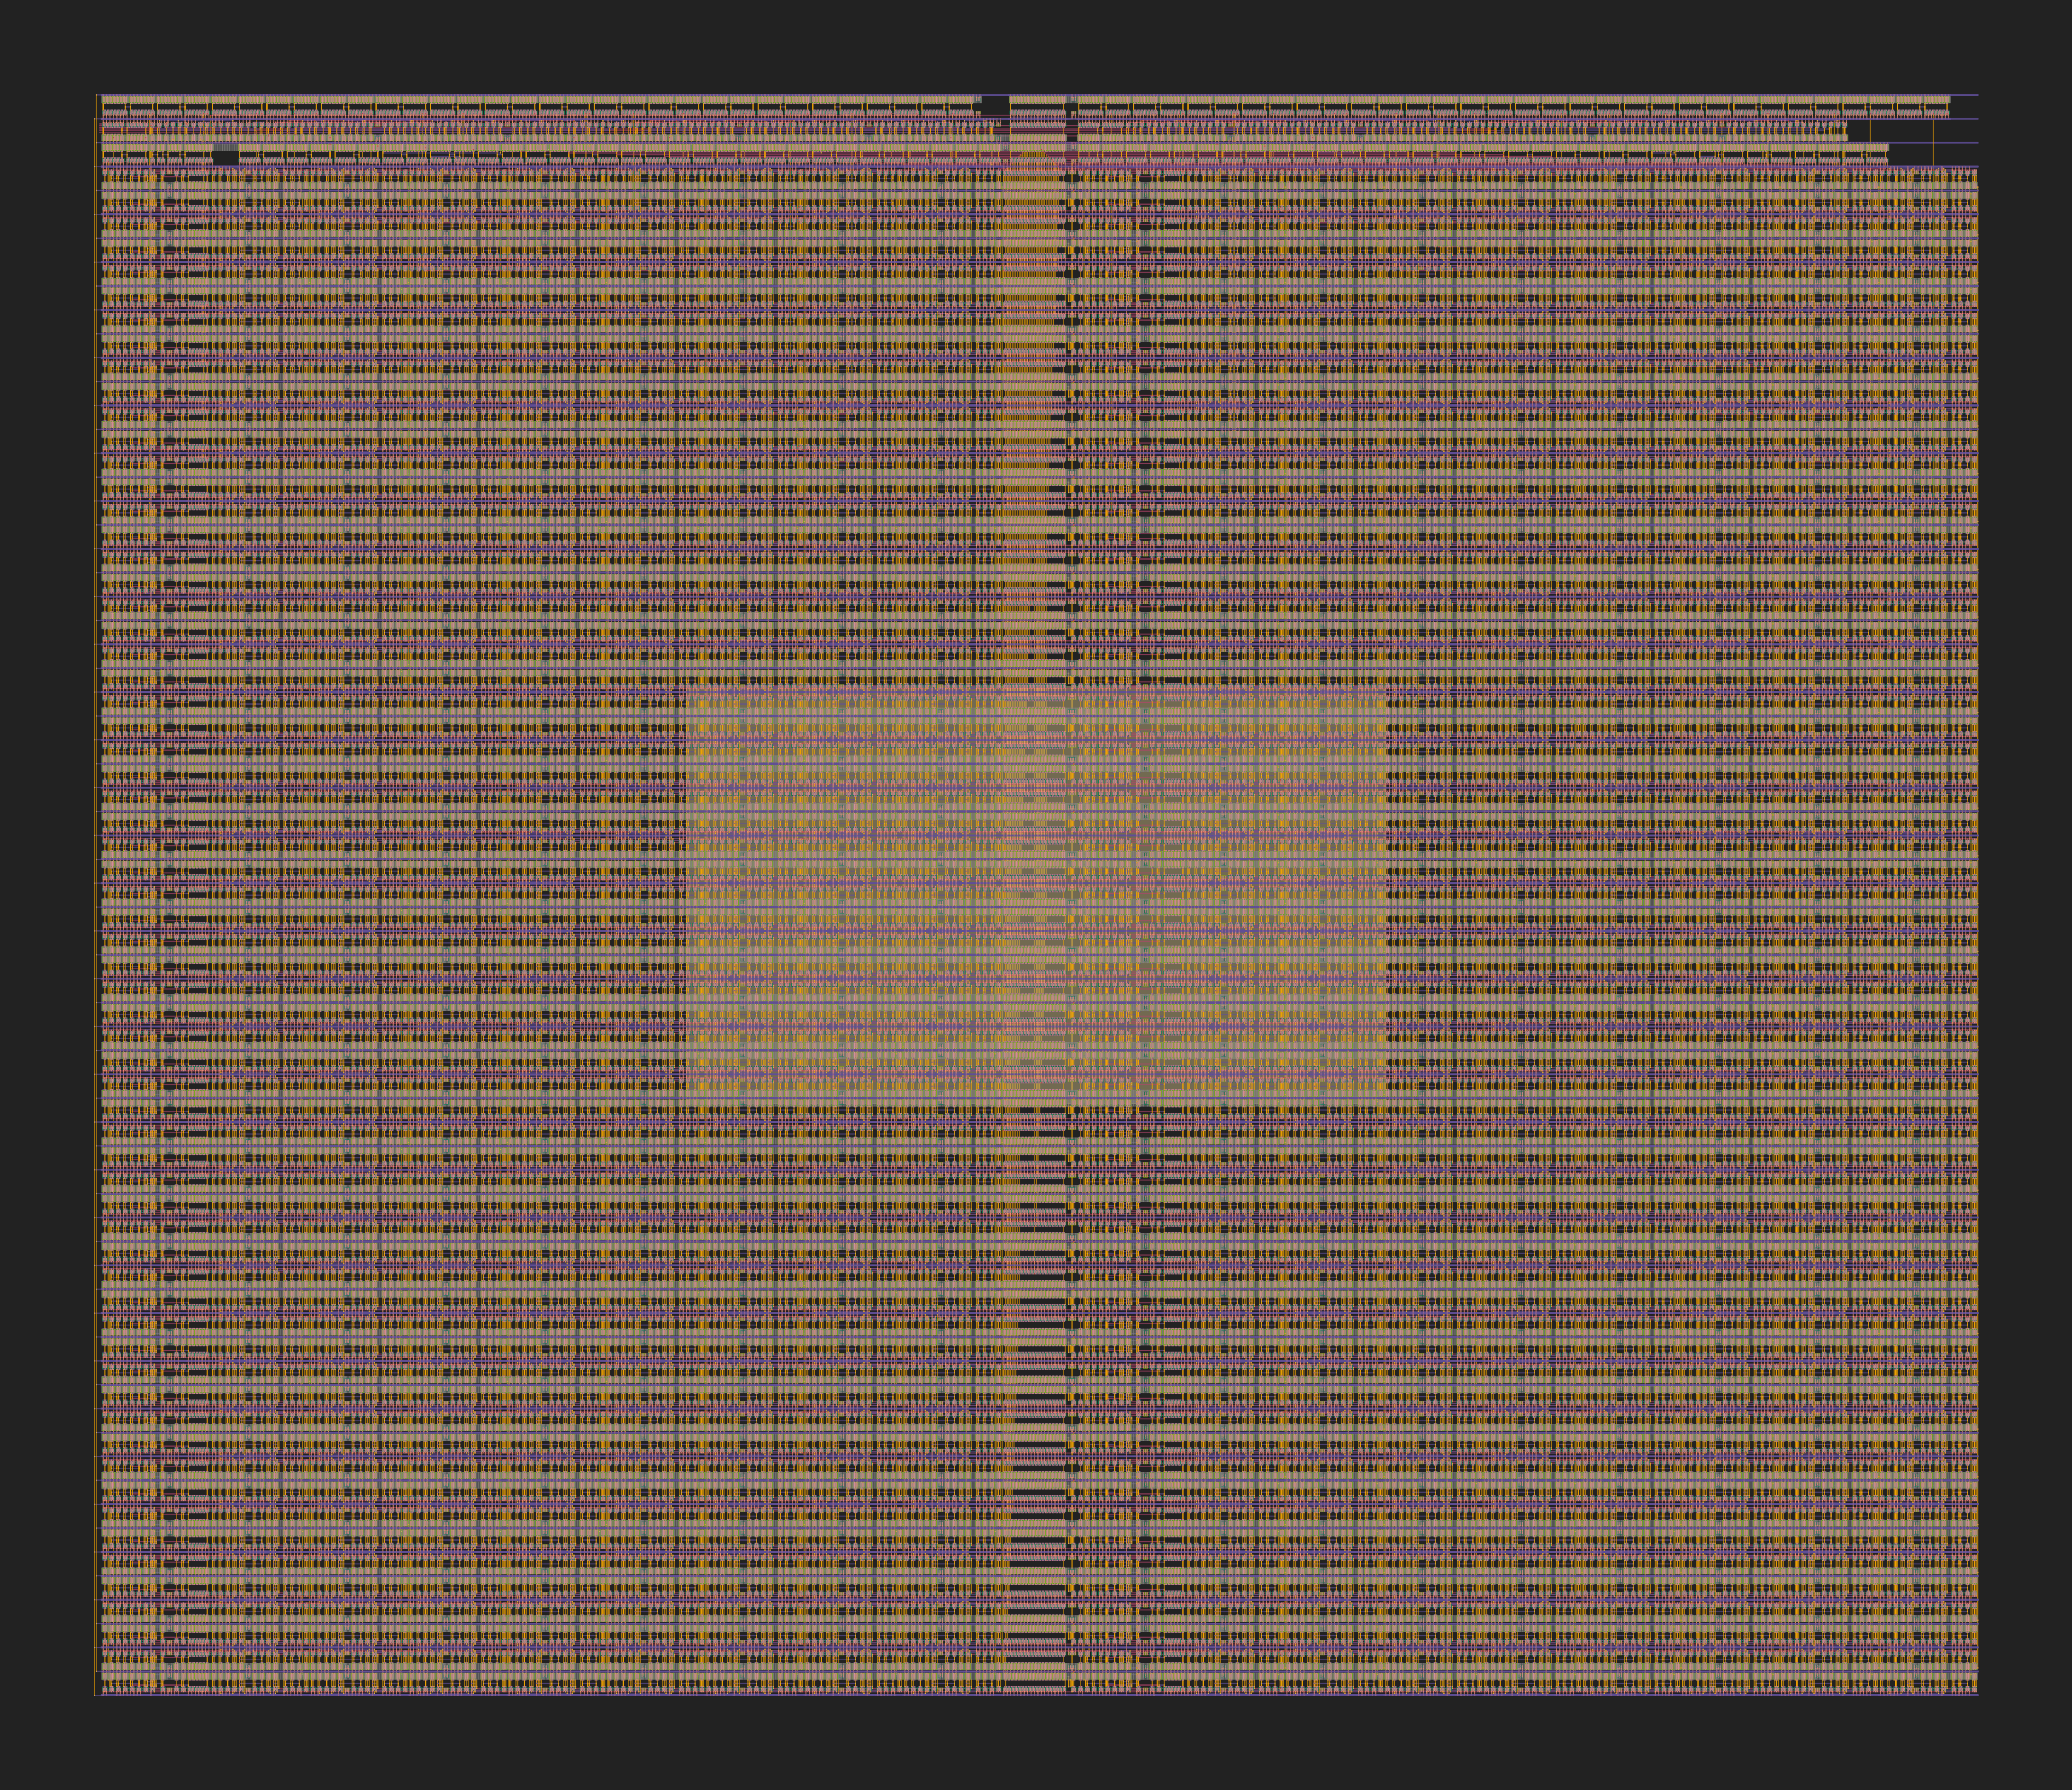

In [ ]:
import gdstk
import cairosvg
from IPython.display import Image

library = gdstk.read_gds('RAM32_full_custom.gds')
#print(library.cells)
top_cells = library.top_level()
top_cells[0].write_svg('RAM32_full_custom.svg')
cairosvg.svg2png(url='RAM32_full_custom.svg', write_to='RAM32_full_custom.png', scale=0.5)
Image('RAM32_full_custom.png')

### LVS Check

In [ ]:
%%script bash -c "netgen -noconsole" 
lvs {RAM32_lvs.spice RAM32_lvs} {lvs_example/RAM32bit.spice RAM32bit} TCL_scripts/setup.tcl lvs_RAM32.out
exit

### Print LVS Results

If "Netlists match uniquely" or "Netlists match uniquely with port errors" appears in the output, we pass the check.

"Pin match fail" error message may appears, you can ignore it since this LVS test have passed in Linux machine.

If checking the message is hard due to too long result-log, you can download 'lvs_RAM32.out' in /content/laygo2_workspace_sky130 dir.

In [ ]:
f = open("lvs_RAM32.out", "r") 
while True:
    line = f.readline()
    if not line: break
    print(line)
f.close()

### NGSPICE Simulation

Run ngspice through pyspice for simulating write operation.
In this simulation, We will turn on eight word lines from word[0] to word[28]. That is, we will activate it in the order of [0, 4, 8, 12, 16, 20, 24, 28].
And we will also test 'DFF-byte cell' for each loop.

###Generate output log file

Following test bench spice file generates simulation result log file 'log_tb_RAM_write.out', which has voltage flow log of probed nodes.

In [ ]:
%%writefile tb_RAM32.spice
.title tb_RAM32
.lib /usr/local/share/pdk/sky130A/libs.tech/ngspice/sky130.lib.spice tt
.include /content/laygo2_workspace_sky130/lvs_example/RAM32bit.spice
XSCH SEL3 SEL4 EN SEL2 SEL1 SEL0 Di0 Do[0] Di1 Do[1] Di2 Do[2] Di3 Do[3] Di0 Do[4] Di1 Do[5] Di2 Do[6] Di3 Do[7] Di0 Do[8] Di1 Do[9] Di2 Do[10] Di3 Do[11] Di0 Do[12] Di1 Do[13] Di2 Do[14] Di3 Do[15] Di0 Do[16] Di1 Do[17] Di2 Do[18] Di3 Do[19] Di0 Do[20] Di1 Do[21] Di2 Do[22] Di3 Do[23] Di3 Do[24] Di3 Do[25] Di3 Do[26] Di3 Do[27] Di3 Do[28] Di3 Do[29] Di3 Do[30] Di3 Do[31] VDD 0 WE0 WE1 WE2 WE3 clk RAM32bit
Vpower VDD 0 1.8
**RAM32 Turns on at 10ns
Ven EN 0 DC 0V PULSE(0V 1.8V 10ns 1ns 1ns 90ns 100ns)
Vsel0 SEL0 0 0
Vsel1 SEL1 0 0
Vwe0 WE0 0 1.8
Vwe1 WE1 0 1.8
Vwe2 WE2 0 1.8
Vwe3 WE3 0 1.8
**100mhz test
Vdi0 Di0 0 DC 0V PULSE(0V 1.8V 10ns 1ns 1ns 8ns 40ns)
Vdi1 Di1 0 DC 0V PULSE(0V 1.8V 20ns 1ns 1ns 8ns 40ns)
Vdi2 Di2 0 DC 0V PULSE(0V 1.8V 30ns 1ns 1ns 8ns 40ns)
Vdi3 Di3 0 DC 0V PULSE(0V 1.8V 40ns 1ns 1ns 8ns 40ns)
Vclk clk 0 DC 0V PULSE(0V 1.8V 4.5ns 0.5ns 0.5ns 4.5ns 10ns)
Vsel2 SEL2 0 DC 0V PULSE(0V 1.8V 20ns 1ns 1ns 8ns 20ns)
Vsel3 SEL3 0 DC 0V PULSE(0V 1.8V 30ns 1ns 1ns 18ns 40ns)
Vsel4 SEL4 0 DC 0V PULSE(0V 1.8V 50ns 1ns 1ns 38ns 80ns)
.end
.control
save all
tran 0.1n 91n
wrdata log_tb_RAM_write.out
* CLK(include fanout buffer), SEL control
+ v(clk) v(xsch.clk_buf) v(sel2) v(sel3) v(sel4)
* Data in
+ v(di0) v(di1) v(di2) v(di3)
* DFF out
+ v(xsch.xbyte1.xbyte_1.dffout0) v(xsch.xbyte5.xbyte_1.dffout0) v(xsch.xbyte9.xbyte_1.dffout0) v(xsch.xbyte13.xbyte_1.dffout0)
+ v(xsch.xbyte17.xbyte_1.dffout0) v(xsch.xbyte21.xbyte_1.dffout0) v(xsch.xbyte25.xbyte_1.dffout0) v(xsch.xbyte29.xbyte_1.dffout0)
+ v(xsch.xbyte1.xbyte_2.dffout1) v(xsch.xbyte5.xbyte_2.dffout1) v(xsch.xbyte9.xbyte_2.dffout1) v(xsch.xbyte13.xbyte_2.dffout1)
+ v(xsch.xbyte17.xbyte_2.dffout1) v(xsch.xbyte21.xbyte_2.dffout1) v(xsch.xbyte25.xbyte_2.dffout1) v(xsch.xbyte29.xbyte_2.dffout1)
+ v(xsch.xbyte1.xbyte_3.dffout2) v(xsch.xbyte5.xbyte_3.dffout2) v(xsch.xbyte9.xbyte_3.dffout2) v(xsch.xbyte13.xbyte_3.dffout2)
+ v(xsch.xbyte17.xbyte_3.dffout2) v(xsch.xbyte21.xbyte_3.dffout2) v(xsch.xbyte25.xbyte_3.dffout2) v(xsch.xbyte29.xbyte_3.dffout2)
+ v(xsch.xbyte1.xbyte_4.dffout3) v(xsch.xbyte5.xbyte_4.dffout3) v(xsch.xbyte9.xbyte_4.dffout3) v(xsch.xbyte13.xbyte_4.dffout3)
+ v(xsch.xbyte17.xbyte_4.dffout3) v(xsch.xbyte21.xbyte_4.dffout3) v(xsch.xbyte25.xbyte_4.dffout3) v(xsch.xbyte29.xbyte_4.dffout3)
* DFF clk input
+ v(xsch.xbyte1.xbyte_1.ck_o) v(xsch.xbyte5.xbyte_1.ck_o) v(xsch.xbyte9.xbyte_1.ck_o) v(xsch.xbyte13.xbyte_1.ck_o)
+ v(xsch.xbyte17.xbyte_1.ck_o) v(xsch.xbyte21.xbyte_1.ck_o) v(xsch.xbyte25.xbyte_1.ck_o) v(xsch.xbyte29.xbyte_1.ck_o)
.endc


Writing tb_RAM32.spice


### Run Simulation

Note: It might take more than an hour

In [ ]:
!ngspice -b -r tbRAM_write.raw tb_RAM32.spice

### Read and Parse 'log_tb_RAM_write.out'. 

Result log is parsed into dataframe table named 'df'.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("log_tb_RAM_write.out", delim_whitespace=True, header=None)
dats = ["time0", "CLK", "time1", "clk_buf", 'time2', 'SEL2', 'time3', 'SEL3', 'time4', 'SEL4']
for i in range(4):
    dats.append('time%d'%(5+2*i))
    dats.append('di'+str(i))
idx = 9
for j in range(4):
    for i in range(8): 
        dats.append("time%d"%(idx))
        dats.append("WORD[%d].byte[%d].dffout%d" %(i*4, j, j))
        idx+=1
for i in range(8):
    dats.append("time%d"%(idx))
    dats.append("WORD[%d].ck_o"%(i*4))
    idx+=1
df.columns = dats

###Plot clock input and clock-buffer for fanout

You can see the delay of large fanout clock signal is very small compare to the clock period 10ns.

![SIM_RAM_CLK](https://drive.google.com/uc?id=1ZCj1z31x8iapi3UlCnr_SBOAFQW6y8Wx)

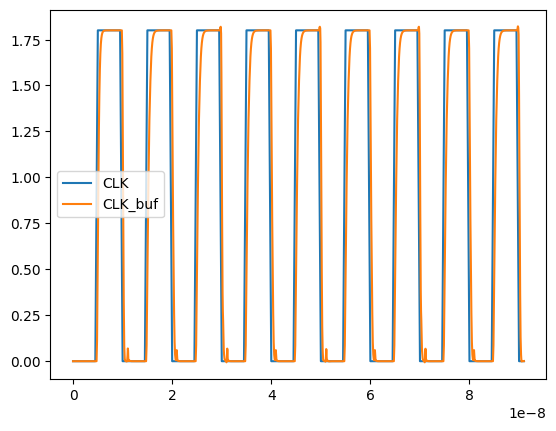

In [ ]:
plt.plot(df['time0'],df['CLK'])
plt.plot(df['time0'],df['clk_buf'])
plt.legend(('CLK', 'CLK_buf'))
plt.show()

### Plot Select control bit

This three bit stands for three MSB bits of the 5-bit select control signal SEL2, SEL3, and SEL4.

The other two bits SEL0 and SEL1 are pinned at 0. So input SEL binary number list is [0, 4, 8, 12, 16, 20, 24, 28].

![SIM_RAM_SEL](https://drive.google.com/uc?id=1LNQm6TD2IdGQAQxCyI4Ze5St_TzA9NJ3)

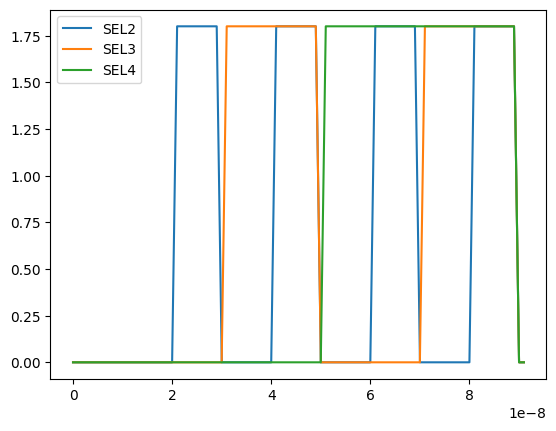

In [ ]:
plt.plot(df['time0'], df['SEL2'])
plt.plot(df['time0'], df['SEL3'])
plt.plot(df['time0'], df['SEL4'])
plt.legend(('SEL2', 'SEL3', 'SEL4'))
plt.show()

### Plot write operation test for Byte[0].

note1: CLK_WORD[0] means output of CLK-gate of WORD[0].

note2: The 'EN' signal(turn on whole RAM32) enabled at '10ns'. So WORD[0] output dosen't change right after CLK on.

#### 'Do[0]' signal should follow 'Di[0]' signal at the 'rising edge' of CLK_WORD

The result plot should have similar form of this figure below.

![SiM_RAM_Write](https://drive.google.com/uc?id=10b47OwT3opXjtdBP6Cxi4OPoC0AjkVTW)


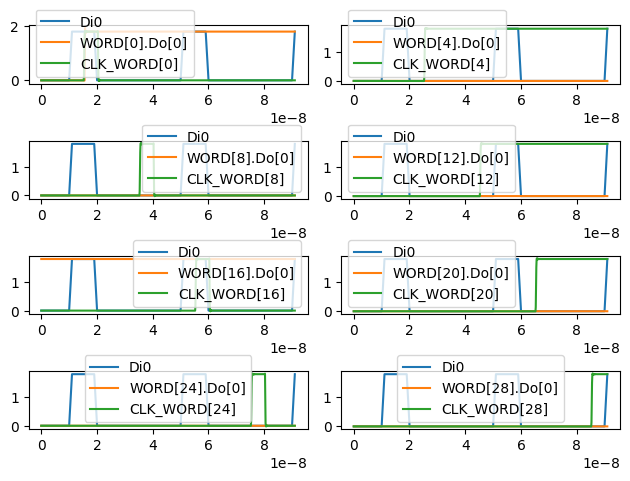

In [ ]:
for i in range(8):
    plt.subplot(4,2,i+1)
    plt.plot(df['time0'],df['di0'])
    plt.plot(df['time0'],df['WORD[%d].byte[0].dffout0'%(i*4)])
    plt.plot(df['time0'],df['WORD[%d].ck_o'%(i*4)])
    plt.legend(('Di0', 'WORD[%d].Do[0]'%(i*4), 'CLK_WORD[%d]'%(i*4)))
plt.tight_layout()
plt.show()

### Plot for Byte[1], Byte[2], Byte[3]

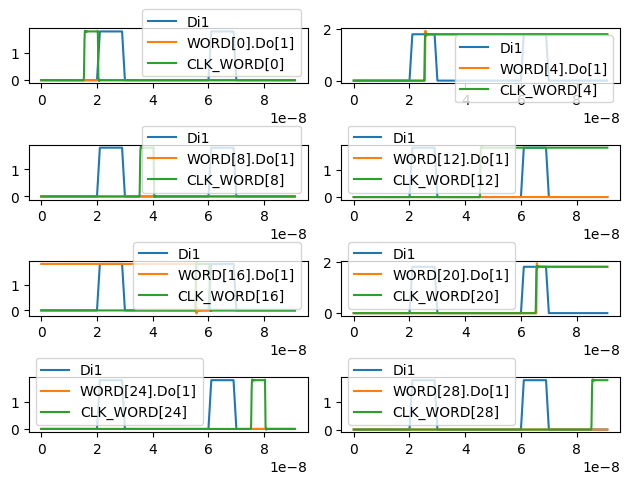

In [ ]:
for i in range(8):
    plt.subplot(4,2,i+1)
    plt.plot(df['time0'],df['di1'])
    plt.plot(df['time0'],df['WORD[%d].byte[1].dffout1'%(i*4)])
    plt.plot(df['time0'],df['WORD[%d].ck_o'%(i*4)])
    plt.legend(('Di1', 'WORD[%d].Do[1]'%(i*4), 'CLK_WORD[%d]'%(i*4)))
plt.tight_layout()
plt.show()

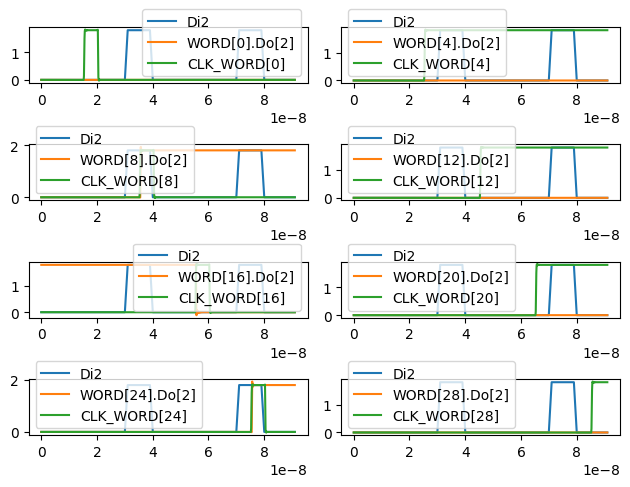

In [ ]:
for i in range(8):
    plt.subplot(4,2,i+1)
    plt.plot(df['time0'],df['di2'])
    plt.plot(df['time0'],df['WORD[%d].byte[2].dffout2'%(i*4)])
    plt.plot(df['time0'],df['WORD[%d].ck_o'%(i*4)])
    plt.legend(('Di2', 'WORD[%d].Do[2]'%(i*4), 'CLK_WORD[%d]'%(i*4)))
plt.tight_layout()
plt.show()

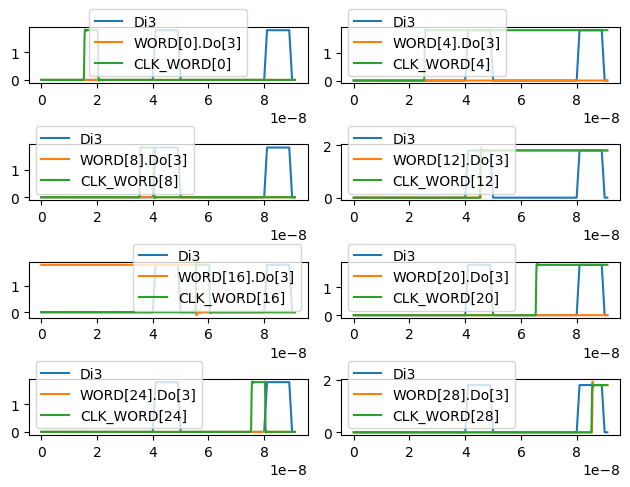

In [ ]:
for i in range(8):
    plt.subplot(4,2,i+1)
    plt.plot(df['time0'],df['di3'])
    plt.plot(df['time0'],df['WORD[%d].byte[3].dffout3'%(i*4)])
    plt.plot(df['time0'],df['WORD[%d].ck_o'%(i*4)])
    plt.legend(('Di3', 'WORD[%d].Do[3]'%(i*4), 'CLK_WORD[%d]'%(i*4)))
plt.tight_layout()
plt.show()

## **Yosys Integration : Laygo2 with Verilog**

By utilizing laygo2, it is now possible to add the ability to generate a layout from Verilog hardware description.

Combined with the open-source synthesis tool (yosys), this process can make the layout structuring process easier, and it allows for the creation of custom layouts from the behavioral level description.

Furthermore, this process can also enable the construction of layouts using custom cells optimized for the target application, going beyond the use of standard cells and making it easier to describe.


### Install Yosys

In [17]:
%cd /content/
!rm -rf yosys
!git clone https://github.com/YosysHQ/yosys.git

%cd /content/yosys/
!make
!make install

/content
Cloning into 'yosys'...
remote: Enumerating objects: 71793, done.
remote: Counting objects: 100% (372/372), done.
remote: Compressing objects: 100% (163/163), done.
remote: Total 71793 (delta 213), reused 334 (delta 209), pack-reused 71421
Receiving objects: 100% (71793/71793), 23.50 MiB | 18.93 MiB/s, done.
Resolving deltas: 100% (52827/52827), done.
/content/yosys
[  0%] Building kernel/version_cee3cb31b.cc
[  0%] Building kernel/version_cee3cb31b.o
[  0%] Building kernel/driver.o
[  0%] Building techlibs/common/simlib_help.inc
[  0%] Building techlibs/common/simcells_help.inc
[  0%] Building kernel/register.o
[  1%] Building kernel/rtlil.o
[  1%] Building kernel/log.o
[  1%] Building kernel/calc.o
[  2%] Building kernel/yosys.o
[  2%] Building kernel/binding.o
[  2%] Building kernel/cellaigs.o
[  3%] Building kernel/celledges.o
[  3%] Building kernel/satgen.o
[  3%] Building kernel/qcsat.o
[  4%] Building kernel/mem.o
[  4%] Building kernel/ffmerge.o
[  4%] Building kernel/

In this example, we present the layout generation of the **RAM8**, with subcells made by verilog netlists.\
Subcell layouts of **buffers**, **4-input and gate**, and **3-input to 8-output decoder** are provided by translating \
instance specified verilog code into python netlist class instances using Pyverilog.

The following is the code how we parsed a verilog file into a python variable :
( used function "info_from_verilog_code" from "pares_from_v.py" )

In [46]:
with open('/content/laygo2_workspace_sky130/laygo2_example/verilog_to_laygo/parse_from_v.py', 'r') as f:
    print(f.read())

###########################################
#                                         #
#  parsing information from verilog code  #
#           Created by S.Y. Lee           #
#                                         #
###########################################

from __future__ import absolute_import
from __future__ import print_function
import sys
import os

# the next line can be removed after installation
sys.path.insert(0, os.path.dirname(os.path.dirname(os.path.abspath(__file__))))

import pyverilog
from pyverilog.vparser.parser import parse

def info_from_verilog_code(filename):

    filelist = [filename]

    for f in filelist:
        if not os.path.exists(f):
            raise IOError("file not found: " + f)
    
    ast, directives = parse(filelist)

    # ast.show()

    # =========== Extract Module info =========== #
    ModuleDef = ast.children()  # start from source object
    while True:
        for el in ModuleDef:
            if type(el) != pyverilog.vparser.ast.Modu

###Prepare subcells from other library

In [47]:
%cd /content/laygo2_workspace_sky130/

/content/laygo2_workspace_sky130


In [48]:
%%script bash -c "PDK_ROOT=/usr/local/share/pdk PDKPATH=/usr/local/share/pdk/sky130A magic -dnull -noconsole -rcfile /usr/local/share/pdk/sky130A/libs.tech/magic/sky130A.magicrc"
addpath /content/laygo2_workspace_sky130/magic_layout/skywater130_microtemplates_dense
addpath /content/laygo2_workspace_sky130/magic_layout/logic_generated
addpath /content/laygo2_workspace_sky130/magic_layout/logic_advanced
addpath /content/laygo2_workspace_sky130/magic_layout/verilog_to_laygo

source laygo2_example/logic/TCL/logic_generated_inv_2x.tcl
source laygo2_example/logic/TCL/logic_generated_inv_12x.tcl
source laygo2_example/logic/TCL/logic_generated_inv_14x.tcl
source laygo2_example/logic/TCL/logic_generated_inv_24x.tcl
source laygo2_example/logic/TCL/logic_generated_inv_32x.tcl

source laygo2_example/logic/TCL/logic_generated_tinv_2x.tcl
source laygo2_example/logic/TCL/logic_generated_tinv_4x.tcl
source laygo2_example/logic/TCL/logic_generated_tinv_small_1x.tcl

source laygo2_example/logic/TCL/logic_generated_space_1x.tcl
source laygo2_example/logic/TCL/logic_generated_space_2x.tcl
source laygo2_example/logic/TCL/logic_generated_space_4x.tcl
source laygo2_example/logic/TCL/logic_generated_space_8x.tcl
source laygo2_example/logic/TCL/logic_generated_space_14x.tcl

source laygo2_example/logic/TCL/logic_generated_nand_2x.tcl
source laygo2_example/logic/TCL/logic_generated_nand3_2x.tcl
source laygo2_example/logic/TCL/logic_generated_nor_2x.tcl

source laygo2_example/logic/TCL/logic_generated_TAP.tcl
source laygo2_example/logic/TCL/logic_generated_latch_2ck_2x.tcl
source laygo2_example/logic/TCL/logic_generated_dff_2x.tcl

source laygo2_example/logic_advance/TCL/logic_advanced_cgate_2x.tcl
source laygo2_example/logic_advance/TCL/logic_advanced_byte_dff_2x.tcl

exit


Magic 8.3 revision 389 - Compiled on Wed Apr 12 10:38:02 UTC 2023.
Starting magic under Tcl interpreter
Using the terminal as the console.
Using NULL graphics device.
Processing system .magicrc file
Sourcing design .magicrc for technology sky130A ...
2 Magic internal units = 1 Lambda
Input style sky130(): scaleFactor=2, multiplier=2
The following types are not handled by extraction and will be treated as non-electrical types:
    ubm 
Scaled tech values by 2 / 1 to match internal grid scaling
Loading sky130A Device Generator Menu ...
Using technology "sky130A", version 1.0.406-0-g0c37b7c
Scaled magic input cell nmos13_fast_boundary geometry by factor of 2
Scaled magic input cell via_M1_M2_0 geometry by factor of 2
Scaled magic input cell via_M1_M2_1 geometry by factor of 2
Scaled magic input cell pmos13_fast_boundary geometry by factor of 2
Scaled magic input cell via_M2_M3_0 geometry by factor of 2
Magic error: writing out-of-date timestamp for logic_generated_inv_2x.
Magic error: wr

Cell NoName_2 (via_M2_M3_0) isn't a child of the edit cell.
    Cell identifier not changed.
Cell NoName_3 (via_M2_M3_0) isn't a child of the edit cell.
    Cell identifier not changed.
Cell NoName_5 (via_M2_M3_0) isn't a child of the edit cell.
    Cell identifier not changed.
Cell NoName_3 (via_M2_M3_0) isn't a child of the edit cell.
    Cell identifier not changed.
Cell NoName_5 (via_M2_M3_0) isn't a child of the edit cell.
    Cell identifier not changed.


### Buffer (with synthesized verilog files)

ex) buffer_14x.v

In [49]:
with open('/content/laygo2_workspace_sky130/laygo2_example/verilog_to_laygo/verilog_codes/buffer_14x.v', 'r') as f:
    print(f.read())

////////////////////////////////////////////
//                                        //
//           buffer verilog code          //
//          Created by S.Y. LEE           //
//                                        //
////////////////////////////////////////////

module buffer_14x(I, O);
    input I;
    output wire O;

    wire w1;

    inv_14x inv0(.I(I), .O(w1));
    inv_14x inv1(.I(w1), .O(O));
endmodule


In [50]:
%cd /content/laygo2_workspace_sky130/laygo2_example/verilog_to_laygo

import numpy as np
import pprint
import laygo2
import laygo2.interface
import laygo2_tech as tech

from parse_from_v import info_from_verilog_code

# Parameter definitions #############
# Variables
cell_type = 'buffer'
# Templates
tpmos_name = 'pmos_sky'
tnmos_name = 'nmos_sky'
tptap_name = 'ptap_sky'
tntap_name = 'ntap_sky'
# Grids
pg_name = 'placement_basic'
r12_name = 'routing_12_cmos'
r23_basic_name = 'routing_23_basic'
r23_cmos_name = 'routing_23_cmos'
r34_name = 'routing_34_basic'
# Design hierarchy
libname = 'verilog_to_laygo'
ref_dir_template = '/content/laygo2_workspace_sky130/laygo2_example/logic'        # reference logic library
ref_dir_export = f'/content/laygo2_workspace_sky130/laygo2_example/{libname}'
ref_dir_MAG_exported = f'/content/laygo2_workspace_sky130/laygo2_example/{libname}/TCL'
ref_dir_layout = '/content/laygo2_workspace_sky130/magic_layout'
# End of parameter definitions ######

# Generation start ##################
# 1. Load templates and grids.
print("Load templates")
templates = tech.load_templates()
tpmos, tnmos = templates[tpmos_name], templates[tnmos_name]
tlib = laygo2.interface.yaml.import_template(filename=f"{ref_dir_template}/logic_generated_templates.yaml")

print("Load grids")
grids = tech.load_grids(templates=templates)
pg, r12, r23_cmos, r23, r34 = grids[pg_name], grids[r12_name], grids[r23_cmos_name], grids[r23_basic_name], grids[r34_name]

nf_list = [2, 12, 14, 24, 36]
for nf in nf_list:
    cellname = f"{cell_type}_{nf}x"
    print('--------------------')
    print('Now Creating '+cellname)

    # 2. Create a design hierarchy
    lib = laygo2.object.database.Library(name=libname)
    dsn = laygo2.object.database.Design(name=cellname, libname=libname)
    lib.append(dsn)

    # 3. Create instances.
    print("Create instances")
    # input verilog file
    verilog_filename = f"{cellname}.v"
    name, paramlist, decl_info, inst_info = \
      info_from_verilog_code(f"/content/laygo2_workspace_sky130/laygo2_example/{libname}/verilog_codes/{verilog_filename}")

    print()
    print(name)
    print(paramlist)
    print(decl_info)
    for i in inst_info :
        print(i)

    PINS = dict()
    for portname in decl_info["Input"]+decl_info["Output"]+decl_info["Input"]:
        PINS[portname] = portname
    WIRES = decl_info["Wire"]

    instances = []; instances_tlib = []
    for instance in inst_info:
        instances_tlib.append(instance["Module"])
        instances.append(tlib[instance["Module"]].generate(name=instance["name"], netmap=instance["portlist"]))


    # 4. Place instances.
    dsn.place(grid=pg, inst=instances, mn=[0,0])

    # 5. Create and place wires.
    print("Create wires")
    # internal
    rc = laygo2.object.template.routing.RoutingMeshTemplate(grid=r23)
    # Nodes
    rc.add_node(list(dsn.instances.values()))  # Add all instances to the routing mesh as nodes
    # Tracks
    # ------------- to prevent making tracks with only one node ------------- #
    nets_for_count = []
    for node in rc.nodes:
        for net in node.pins.values():
            if net.netname not in ['VDD', 'VSS', 'vdd', 'vss']:
                nets_for_count.append(net.netname)
    # ----------------------------------------------------------------------- #
    # *** define the starting track (parallel to x axis) *** #              #||
    _trk = (r23.mn(instances[1].pins['I'])[0,1] + r23.mn(instances[1].pins['I'])[1,1])/2    #||
    # ****************************************************** #              #||
    m = 0                                                                   #||
    for n, w in enumerate(WIRES):                                           #||
        if nets_for_count.count(w) != 1: # <<================================||
            rc.add_track(name=f"{w}_net", index=[None, _trk + n - m], netname=w)
        else: m += 1
    rinst = rc.generate()
    dsn.place(grid=pg, inst=rinst)

    # VSS
    rvss0 = dsn.route(grid=r12, mn=[r12.mn.bottom_left(instances[0]), r12.mn.bottom_right(instances[-1])])
    # VDD
    rvdd0 = dsn.route(grid=r12, mn=[r12.mn.top_left(instances[0]), r12.mn.top_right(instances[-1])])


    # 6. Create pins.
    cur_pins = []
    for p in PINS.keys(): # PINS.keys() : pin names
        # current order
        for n, i in enumerate(instances):
            cur_netnames = [x.netname for x in i.pins.values()] # netnames in instance i
            if PINS[p] in cur_netnames:   # p : pin names user defines, PINS[p] : netnames corresponding to pin name p
                if p in [pin.netname for pin in cur_pins]: continue     # only save each pins once
                cur_port_key = list(i.pins.keys())[cur_netnames.index(PINS[p])] # cur_netnames is from i.pins.values (converted to string)
                cur_pins.append(dsn.pin(name=p, grid=r23_cmos, mn=r23_cmos.mn.bbox(i.pins[cur_port_key])))
                                        # name as user defined pin name (p)       # need pin name of the instance i (cur_port_key)
                                                                                    # that is connected to the netname PINS[p]
    pvss0 = dsn.pin(name='VSS', grid=r12, mn=r12.mn.bbox(rvss0))
    pvdd0 = dsn.pin(name='VDD', grid=r12, mn=r12.mn.bbox(rvdd0))


    # 7. Export to physical database.
    print("Export design")

    # Uncomment for BAG export
    laygo2.interface.magic.export(lib, filename=f"{ref_dir_MAG_exported}/{libname}_{cellname}.tcl", cellname=None, libpath=ref_dir_layout, scale=1, reset_library=False, tech_library='sky130A')

    # 8. Export to a template database file.
    nat_temp = dsn.export_to_template()
    laygo2.interface.yaml.export_template(nat_temp, filename=f"{ref_dir_export}/{libname}_templates.yaml", mode='append')
    

/content/laygo2_workspace_sky130/laygo2_example/verilog_to_laygo
Load templates
Load grids
--------------------
Now Creating buffer_2x
Create instances


Generating LALR tables



buffer_2x
()
{'Input': ['I'], 'Output': ['O'], 'Inout': [], 'Wire': ['O', 'w1'], 'Reg': [], 'Integer': []}
{'Module': 'inv_2x', 'name': 'inv0', 'paramlist': (), 'portlist': {'I': 'I', 'O': 'w1'}}
{'Module': 'inv_2x', 'name': 'inv1', 'paramlist': (), 'portlist': {'I': 'w1', 'O': 'O'}}
Create wires
Export design
--------------------
Now Creating buffer_12x
Create instances


Generating LALR tables



buffer_12x
()
{'Input': ['I'], 'Output': ['O'], 'Inout': [], 'Wire': ['O', 'w1'], 'Reg': [], 'Integer': []}
{'Module': 'inv_12x', 'name': 'inv0', 'paramlist': (), 'portlist': {'I': 'I', 'O': 'w1'}}
{'Module': 'inv_12x', 'name': 'inv1', 'paramlist': (), 'portlist': {'I': 'w1', 'O': 'O'}}
Create wires
Export design
--------------------
Now Creating buffer_14x
Create instances


Generating LALR tables



buffer_14x
()
{'Input': ['I'], 'Output': ['O'], 'Inout': [], 'Wire': ['O', 'w1'], 'Reg': [], 'Integer': []}
{'Module': 'inv_14x', 'name': 'inv0', 'paramlist': (), 'portlist': {'I': 'I', 'O': 'w1'}}
{'Module': 'inv_14x', 'name': 'inv1', 'paramlist': (), 'portlist': {'I': 'w1', 'O': 'O'}}
Create wires
Export design
--------------------
Now Creating buffer_24x
Create instances


Generating LALR tables



buffer_24x
()
{'Input': ['I'], 'Output': ['O'], 'Inout': [], 'Wire': ['O', 'w1'], 'Reg': [], 'Integer': []}
{'Module': 'inv_24x', 'name': 'inv0', 'paramlist': (), 'portlist': {'I': 'I', 'O': 'w1'}}
{'Module': 'inv_24x', 'name': 'inv1', 'paramlist': (), 'portlist': {'I': 'w1', 'O': 'O'}}
Create wires
Export design
--------------------
Now Creating buffer_36x
Create instances


Generating LALR tables



buffer_36x
()
{'Input': ['I'], 'Output': ['O'], 'Inout': [], 'Wire': ['O', 'w1'], 'Reg': [], 'Integer': []}
{'Module': 'inv_36x', 'name': 'inv0', 'paramlist': (), 'portlist': {'I': 'I', 'O': 'w1'}}
{'Module': 'inv_36x', 'name': 'inv1', 'paramlist': (), 'portlist': {'I': 'w1', 'O': 'O'}}
Create wires
Export design


### 4 input AND gate (with synthesized verilog file)

and4_2x.v

In [51]:
with open('/content/laygo2_workspace_sky130/laygo2_example/verilog_to_laygo/verilog_codes/and4_2x.v', 'r') as f:
    print(f.read())

////////////////////////////////////////////
//                                        //
//            AND4 verilog code           //
//           Created by S.Y. LEE          //
//                                        //
////////////////////////////////////////////

module and4_2x(A, B, C, D, O);
    input A, B, C, D;
    output wire O;

    wire w1;
    wire w2;
    
    nand_2x nand0(.A(C), .B(D), .OUT(w1));
    nand_2x nand1(.A(A), .B(B), .OUT(w2));
    nor_2x nor0(.A(w2), .B(w1), .OUT(O));
endmodule


In [52]:
%cd /content/laygo2_workspace_sky130/
exec(open("/content/laygo2_workspace_sky130/laygo2_example/verilog_to_laygo/and4_2x.py").read())

/content/laygo2_workspace_sky130
Load templates
Load grids
--------------------
Now Creating and4_2x
Create instances


Generating LALR tables



and4_2x
()
{'Input': ['A', 'B', 'C', 'D'], 'Output': ['O'], 'Inout': [], 'Wire': ['O', 'w1', 'w2'], 'Reg': [], 'Integer': []}
{'Module': 'nand_2x', 'name': 'nand0', 'paramlist': (), 'portlist': {'A': 'C', 'B': 'D', 'OUT': 'w1'}}
{'Module': 'nand_2x', 'name': 'nand1', 'paramlist': (), 'portlist': {'A': 'A', 'B': 'B', 'OUT': 'w2'}}
{'Module': 'nor_2x', 'name': 'nor0', 'paramlist': (), 'portlist': {'A': 'w2', 'B': 'w1', 'OUT': 'O'}}
Create wires
Export design


### 3 input Decoder (yosys + laygo2)

Especially for dec3x8, we show the full level of conversion of how behavior level description verilog file could be converted to laygo2 layouts.

**====  PRE_SYNTH to POST_SYNTH with yosys : START  ====**

dec3x8_pre_synth_2x.v

In [53]:
with open('/content/laygo2_workspace_sky130/laygo2_example/verilog_to_laygo/verilog_codes/dec3x8_2x_pre_synth.v', 'r') as f:
    print(f.read())

////////////////////////////////////////////
//                                        //
//         decoder3x8 verilog code        //
//            pre yosys synthesis         //
//           Created by S.Y. LEE          //
//                                        //
////////////////////////////////////////////

module dec3x8_2x(A0, A1, A2, EN, O);
    input A0, A1, A2, EN;
    output wire [7:0] O;
    
    always @(*) begin
        case({EN,A2,A1,A0})
            4'b1000 : O = 8'b00000001;
            4'b1001 : O = 8'b00000010;
            4'b1010 : O = 8'b00000100;
            4'b1011 : O = 8'b00001000;
            4'b1100 : O = 8'b00010000;
            4'b1101 : O = 8'b00100000;
            4'b1110 : O = 8'b01000000;
            4'b1111 : O = 8'b10000000;
            default : O = 8'b00000000;
        endcase
    end

endmodule


yosys commands

In [55]:
%cd /content/laygo2_workspace_sky130/laygo2_example/verilog_to_laygo/verilog_codes/
!ls ./dec3x8*

/content/laygo2_workspace_sky130/laygo2_example/verilog_to_laygo/verilog_codes
./dec3x8_2x_pre_synth.v  ./dec3x8_2x_synth.ys


In [56]:
!/content/yosys/yosys dec3x8_2x_synth.ys


 /----------------------------------------------------------------------------\
 |                                                                            |
 |  yosys -- Yosys Open SYnthesis Suite                                       |
 |                                                                            |
 |  Copyright (C) 2012 - 2020  Claire Xenia Wolf <claire@yosyshq.com>         |
 |                                                                            |
 |  Permission to use, copy, modify, and/or distribute this software for any  |
 |  purpose with or without fee is hereby granted, provided that the above    |
 |  copyright notice and this permission notice appear in all copies.         |
 |                                                                            |
 |  THE SOFTWARE IS PROVIDED "AS IS" AND THE AUTHOR DISCLAIMS ALL WARRANTIES  |
 |  WITH REGARD TO THIS SOFTWARE INCLUDING ALL IMPLIED WARRANTIES OF          |
 |  MERCHANTABILITY AND FITNESS. IN NO 

In [57]:
with open('/content/laygo2_workspace_sky130/laygo2_example/verilog_to_laygo/verilog_codes/dec3x8_2x_synth.ys', 'r') as f:
    print(f.read())

read_verilog dec3x8_2x_pre_synth.v
hierarchy -top dec3x8_2x
proc; fsm; opt; memory; opt
techmap; opt
dfflibmap -liberty mycells.lib
abc -liberty mycells.lib
clean
write_verilog dec3x8_2x_post_synth.v


In [58]:
!ls ./dec3x8*

./dec3x8_2x_post_synth.v  ./dec3x8_2x_pre_synth.v  ./dec3x8_2x_synth.ys


A new verilog file (dec3x8_post_synth.v) is made.<br>
Also, note that mycells.lib is a standard library for yosys synthesis

In [59]:
with open('/content/laygo2_workspace_sky130/laygo2_example/verilog_to_laygo/verilog_codes/mycells.lib', 'r') as f:
    print(f.read())

library(demo) {
  cell(buf_2x) {
    area: 6;
    pin(I) { direction: input; }
    pin(O) { direction: output;
              function: "I"; }
  }
  cell(inv_2x) {
    area: 3;
    pin(I) { direction: input; }
    pin(O) { direction: output;
              function: "I'"; }
  }
  cell(nand2_2x) {
    area: 4;
    pin(A) { direction: input; }
    pin(B) { direction: input; }
    pin(O) { direction: output;
             function: "(A*B)'"; }
  }
  cell(nor2_2x) {
    area: 4;
    pin(A) { direction: input; }
    pin(B) { direction: input; }
    pin(O) { direction: output;
             function: "(A+B)'"; }
  }
  cell(and4_2x) {
    area: 12;
    pin(A) { direction: input; }
    pin(B) { direction: input; }
    pin(C) { direction: input; }
    pin(D) { direction: input; }
    pin(O) { direction: output;
             function: "(A*B*C*D)"; }
  }
  cell(dff_4x) {
    area: 18;
    ff(IQ, IQN) { clocked_on: CLK;
                  next_state: I; }
    pin(CLK) { direction: input;
              

dec3x8_post_synth_2x.v

In [60]:
with open('/content/laygo2_workspace_sky130/laygo2_example/verilog_to_laygo/verilog_codes/dec3x8_2x_post_synth.v', 'r') as f:
    print(f.read())

/* Generated by Yosys 0.28+6 (git sha1 cee3cb31b, clang 10.0.0-4ubuntu1 -fPIC -Os) */

(* top =  1  *)
(* src = "dec3x8_2x_pre_synth.v:9.1-27.10" *)
module dec3x8_2x(A0, A1, A2, EN, O);
  wire _00_;
  wire _01_;
  wire _02_;
  (* src = "dec3x8_2x_pre_synth.v:10.11-10.13" *)
  input A0;
  wire A0;
  (* src = "dec3x8_2x_pre_synth.v:10.15-10.17" *)
  input A1;
  wire A1;
  (* src = "dec3x8_2x_pre_synth.v:10.19-10.21" *)
  input A2;
  wire A2;
  (* src = "dec3x8_2x_pre_synth.v:10.23-10.25" *)
  input EN;
  wire EN;
  (* src = "dec3x8_2x_pre_synth.v:11.23-11.24" *)
  output [7:0] O;
  wire [7:0] O;
  inv_2x _03_ (
    .I(A2),
    .O(_00_)
  );
  inv_2x _04_ (
    .I(A0),
    .O(_01_)
  );
  inv_2x _05_ (
    .I(A1),
    .O(_02_)
  );
  and4_2x _06_ (
    .A(EN),
    .B(_00_),
    .C(_01_),
    .D(_02_),
    .O(O[0])
  );
  and4_2x _07_ (
    .A(EN),
    .B(_00_),
    .C(A0),
    .D(_02_),
    .O(O[1])
  );
  and4_2x _08_ (
    .A(EN),
    .B(_00_),
    .C(_01_),
    .D(A1),
    .O(O[2])
  )

**====  PRE_SYNTH to POST_SYNTH with yosys : END  ====**

dec3x8 generation

In [61]:
%cd /content/laygo2_workspace_sky130
exec(open("/content/laygo2_workspace_sky130/laygo2_example/verilog_to_laygo/dec3x8.py").read())

/content/laygo2_workspace_sky130
Load templates
Load grids
--------------------
Now Creating dec3x8_2x
Create instances


Generating LALR tables



dec3x8_2x
()
{'Input': ['A0', 'A1', 'A2', 'EN'], 'Output': ['O[0]', 'O[1]', 'O[2]', 'O[3]', 'O[4]', 'O[5]', 'O[6]', 'O[7]'], 'Inout': [], 'Wire': ['_00_', '_01_', '_02_', 'A0', 'A1', 'A2', 'EN', 'O[0]', 'O[1]', 'O[2]', 'O[3]', 'O[4]', 'O[5]', 'O[6]', 'O[7]'], 'Reg': [], 'Integer': []}
{'Module': 'inv_2x', 'name': '_03_', 'paramlist': (), 'portlist': {'I': 'A2', 'O': '_00_'}}
{'Module': 'inv_2x', 'name': '_04_', 'paramlist': (), 'portlist': {'I': 'A0', 'O': '_01_'}}
{'Module': 'inv_2x', 'name': '_05_', 'paramlist': (), 'portlist': {'I': 'A1', 'O': '_02_'}}
{'Module': 'and4_2x', 'name': '_06_', 'paramlist': (), 'portlist': {'A': 'EN', 'B': '_00_', 'C': '_01_', 'D': '_02_', 'O': 'O[0]'}}
{'Module': 'and4_2x', 'name': '_07_', 'paramlist': (), 'portlist': {'A': 'EN', 'B': '_00_', 'C': 'A0', 'D': '_02_', 'O': 'O[1]'}}
{'Module': 'and4_2x', 'name': '_08_', 'paramlist': (), 'portlist': {'A': 'EN', 'B': '_00_', 'C': '_01_', 'D': 'A1', 'O': 'O[2]'}}
{'Module': 'and4_2x', 'name': '_09_', 'paraml

###Word generation

In [36]:
exec(open("/content/laygo2_workspace_sky130/laygo2_example/verilog_to_laygo/word_32bit.py").read())

Load templates
Load grids
--------------------
Now Creating word_32bit_2x
Create instances
Create wires
Export design


###RAM8 generation

In [37]:
exec(open("/content/laygo2_workspace_sky130/laygo2_example/verilog_to_laygo/RAM8.py").read())

Load templates
Load grids
--------------------
Now Creating ram8_2x
Create instances
Create wires
Export design


### Check TCL files

The following files must have been created.
- laygo2_example/verilog_to_laygo/TCL/verilog_to_laygo_and4_2x.tcl
- laygo2_example/verilog_to_laygo/TCL/verilog_to_laygo_buffer_12x.tcl
- laygo2_example/verilog_to_laygo/TCL/verilog_to_laygo_buffer_14x.tcl
- laygo2_example/verilog_to_laygo/TCL/verilog_to_laygo_buffer_24x.tcl
- laygo2_example/verilog_to_laygo/TCL/verilog_to_laygo_buffer_2x.tcl
- laygo2_example/verilog_to_laygo/TCL/verilog_to_laygo_buffer_36x.tcl
- laygo2_example/verilog_to_laygo/TCL/verilog_to_laygo_dec3x8_2x.tcl
- laygo2_example/verilog_to_laygo/TCL/verilog_to_laygo_ram8_2x.tcl
- laygo2_example/verilog_to_laygo/TCL/verilog_to_laygo_word_32bit_2x.tcl

In [38]:
!ls laygo2_example/verilog_to_laygo/TCL/*.tcl

laygo2_example/verilog_to_laygo/TCL/verilog_to_laygo_and4_2x.tcl
laygo2_example/verilog_to_laygo/TCL/verilog_to_laygo_buffer_12x.tcl
laygo2_example/verilog_to_laygo/TCL/verilog_to_laygo_buffer_14x.tcl
laygo2_example/verilog_to_laygo/TCL/verilog_to_laygo_buffer_24x.tcl
laygo2_example/verilog_to_laygo/TCL/verilog_to_laygo_buffer_2x.tcl
laygo2_example/verilog_to_laygo/TCL/verilog_to_laygo_buffer_36x.tcl
laygo2_example/verilog_to_laygo/TCL/verilog_to_laygo_dec3x8_2x.tcl
laygo2_example/verilog_to_laygo/TCL/verilog_to_laygo_ram8_2x.tcl
laygo2_example/verilog_to_laygo/TCL/verilog_to_laygo_word_32bit_2x.tcl


### Export the final layout in gds format

Now we can read the TCL files with magic to create the layout and extract GDS and SPICE

In [39]:
%cd /content/laygo2_workspace_sky130

/content/laygo2_workspace_sky130


In [41]:
%%script bash -c "PDK_ROOT=/usr/local/share/pdk PDKPATH=/usr/local/share/pdk/sky130A magic -dnull -noconsole -rcfile /usr/local/share/pdk/sky130A/libs.tech/magic/sky130A.magicrc"
addpath /content/laygo2_workspace_sky130/magic_layout/skywater130_microtemplates_dense
addpath /content/laygo2_workspace_sky130/magic_layout/logic_generated
addpath /content/laygo2_workspace_sky130/magic_layout/logic_advanced
addpath /content/laygo2_workspace_sky130/magic_layout/verilog_to_laygo

source laygo2_example/verilog_to_laygo/TCL/verilog_to_laygo_buffer_2x.tcl
source laygo2_example/verilog_to_laygo/TCL/verilog_to_laygo_buffer_12x.tcl
source laygo2_example/verilog_to_laygo/TCL/verilog_to_laygo_buffer_14x.tcl
source laygo2_example/verilog_to_laygo/TCL/verilog_to_laygo_buffer_24x.tcl
source laygo2_example/verilog_to_laygo/TCL/verilog_to_laygo_buffer_36x.tcl
source laygo2_example/verilog_to_laygo/TCL/verilog_to_laygo_and4_2x.tcl
source laygo2_example/verilog_to_laygo/TCL/verilog_to_laygo_dec3x8_2x.tcl
source laygo2_example/logic_advance/TCL/logic_advanced_byte_dff_2x.tcl
source laygo2_example/verilog_to_laygo/TCL/verilog_to_laygo_word_32bit_2x.tcl
source laygo2_example/verilog_to_laygo/TCL/verilog_to_laygo_ram8_2x.tcl

load verilog_to_laygo_ram8_2x
select top cell
gds labels no
gds write RAM8_v2laygo.gds

flatten RAM8_v2laygo_lvs
load RAM8_v2laygo_lvs
extract
ext2spice lvs
ext2spice
exit


Magic 8.3 revision 389 - Compiled on Wed Apr 12 10:38:02 UTC 2023.
Starting magic under Tcl interpreter
Using the terminal as the console.
Using NULL graphics device.
Processing system .magicrc file
Sourcing design .magicrc for technology sky130A ...
2 Magic internal units = 1 Lambda
Input style sky130(): scaleFactor=2, multiplier=2
The following types are not handled by extraction and will be treated as non-electrical types:
    ubm 
Scaled tech values by 2 / 1 to match internal grid scaling
Loading sky130A Device Generator Menu ...
Using technology "sky130A", version 1.0.406-0-g0c37b7c
Scaled magic input cell via_M2_M3_0 geometry by factor of 2
Scaled magic input cell logic_generated_inv_36x geometry by factor of 2
Scaled magic input cell logic_generated_nand_2x geometry by factor of 2
Scaled magic input cell logic_generated_nor_2x geometry by factor of 2
Scaled magic input cell ntap_fast_boundary geometry by factor of 2
Scaled magic input cell ntap_fast_center_nf2_v2 geometry by fa

Duplicate cell in logic_advanced_cgate_2x:  Instance of cell logic_generated_inv_2x is from path /content/laygo2_workspace_sky130/magic_layout/logic_advanced/magic_layout/logic_generated but cell was previously read from /content/laygo2_workspace_sky130/magic_layout/logic_generated.
New path does not exist and will be ignored.
Duplicate cell in logic_advanced_cgate_2x:  Instance of cell logic_generated_inv_12x is from path /content/laygo2_workspace_sky130/magic_layout/logic_advanced/magic_layout/logic_generated but cell was previously read from /content/laygo2_workspace_sky130/magic_layout/logic_generated.
New path does not exist and will be ignored.
Duplicate cell in logic_advanced_cgate_2x:  Instance of cell logic_generated_nand_2x is from path /content/laygo2_workspace_sky130/magic_layout/logic_advanced/magic_layout/logic_generated but cell was previously read from /content/laygo2_workspace_sky130/magic_layout/logic_generated.
New path does not exist and will be ignored.
Duplicate c

### Draw the top-level layout

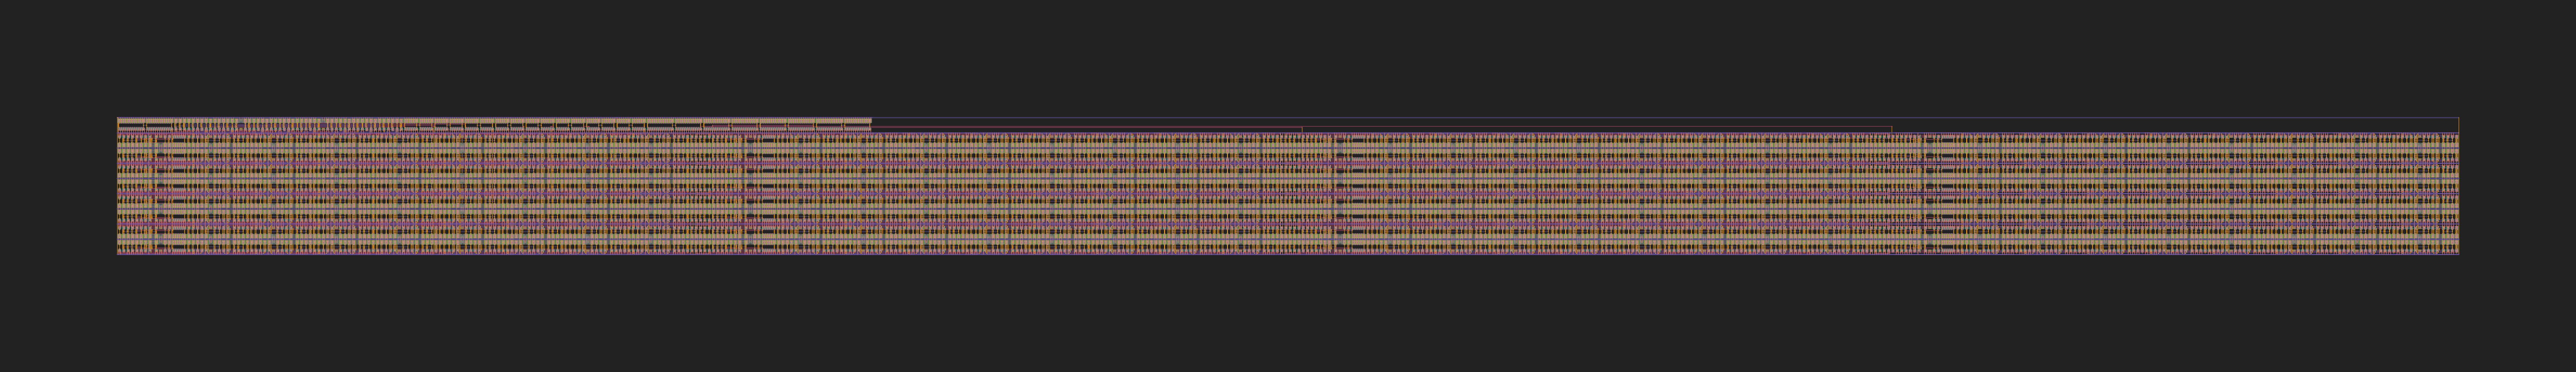

In [42]:
import gdstk
import cairosvg
from IPython.display import Image

library = gdstk.read_gds('RAM8_v2laygo.gds')
#print(library.cells)
top_cells = library.top_level()
top_cells[0].write_svg('RAM8_v2laygo.svg')
cairosvg.svg2png(url='RAM8_v2laygo.svg', write_to='RAM8_v2laygo.png', scale=0.5)
Image('RAM8_v2laygo.png')

###LVS CHECK

In [43]:
%%script bash -c "netgen -noconsole" 
lvs {RAM8_v2laygo_lvs.spice RAM8_v2laygo_lvs} {lvs_example/RAM8_v2laygo/xschem_netlist/RAM8bit.spice RAM8bit} TCL_scripts/setup.tcl lvs_RAM8_v2laygo.out
exit

Netgen 1.5.253 compiled on Wed 03 May 2023 08:56:42 AM UTC
Reading netlist file RAM8_v2laygo_lvs.spice
Call to undefined subcircuit sky130_fd_pr__pfet_01v8
Creating placeholder cell definition.
Call to undefined subcircuit sky130_fd_pr__nfet_01v8_lvt
Creating placeholder cell definition.
Reading netlist file lvs_example/RAM8_v2laygo/xschem_netlist/RAM8bit.spice
Call to undefined subcircuit word
Creating placeholder cell definition.
Call to undefined subcircuit dec_3to8
Creating placeholder cell definition.
Call to undefined subcircuit inv
Creating placeholder cell definition.
Call to undefined subcircuit byte_dff
Creating placeholder cell definition.
Call to undefined subcircuit and_4in
Creating placeholder cell definition.
Call to undefined subcircuit sky130_fd_pr__nfet_01v8_lvt
Creating placeholder cell definition.
Call to undefined subcircuit sky130_fd_pr__pfet_01v8
Creating placeholder cell definition.
Call to undefined subcircuit nand
Creating placeholder cell definition.
Call to 

In [44]:
with open('/content/laygo2_workspace_sky130/lvs_RAM8_v2laygo.out', 'r') as f:
    print(f.read())


Circuit 1 cell sky130_fd_pr__pfet_01v8 and Circuit 2 cell sky130_fd_pr__pfet_01v8 are black boxes.

Subcircuit pins:
Circuit 1: sky130_fd_pr__pfet_01v8         |Circuit 2: sky130_fd_pr__pfet_01v8         
-------------------------------------------|-------------------------------------------
1                                          |1                                          
2                                          |2                                          
3                                          |3                                          
4                                          |4                                          
---------------------------------------------------------------------------------------
Cell pin lists are equivalent.
Device classes sky130_fd_pr__pfet_01v8 and sky130_fd_pr__pfet_01v8 are equivalent.

Circuit 1 cell sky130_fd_pr__nfet_01v8_lvt and Circuit 2 cell sky130_fd_pr__nfet_01v8_lvt are black boxes.

Subcircuit pins:
Circuit 1: sky130_fd_pr__n

## Reference

[1] https://github.com/niftylab/laygo2

[2] https://github.com/AUCOHL/DFFRAM

[3] https://github.com/YosysHQ/yosys

[4] https://openram.org/

[5] https://laygo2-sky130-docs.readthedocs.io/en/main/ (How to setup your own Laygo2-sky130 workspace)